In [1]:
%load_ext autoreload
%autoreload 2
from data_utils import load_news_items, load_movie_data, load_movie_data_saved, select_companies, select_movies
import numpy as np
from Simulation import assign_groups, Usersampler, simulate, get_numerical_relevances
from Documents import Movie
from plotting import combine_and_plot_ndcg_unfairness
%matplotlib inline
from config import ex
import matplotlib.pyplot as plt
import pandas as pd
from plotting import *
import os
import random
from Simulation import *
import numpy as np
from plotting import *
import matplotlib
from progressbar import progressbar
import matplotlib.style
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrckmy')

Using TensorFlow backend.


In [357]:
!zip plots/Asaved/batch_run_dataset1/figure/paper_5.4.zip -jr plots/Asaved/batch_run_dataset1/figure/paper_5.4/*.pdf  

updating: comparison_ndcg_unfairness_at_5.pdf (deflated 35%)
updating: comparison_ndcg_unfairness_top_k.pdf (deflated 36%)
updating: convergence_at_5.pdf (deflated 1%)
  adding: comparison_ndcg_unfairness_at_10.pdf (deflated 36%)
  adding: convergence_at_10.pdf (deflated 1%)


In [111]:
!zip plots/Asaved/batch_run_dataset2_greedy/figure/paper_5.4.zip -jr plots/Asaved/batch_run_dataset2_greedy/figure/paper_5.4/*.pdf  

  adding: comparison_ndcg_unfairness_at_5.pdf (deflated 37%)
  adding: comparison_ndcg_unfairness_top_k.pdf (deflated 35%)
  adding: convergence_at_5.pdf (deflated 1%)


In [2]:
from scipy import stats
import numpy as np
rvs1 = stats.norm.rvs(loc = 5,scale = 3,size = 500)
rvs2 = stats.norm.rvs(loc = 5.5,scale = 4,size = 500)
print(stats.ttest_rel(rvs1,rvs2))

Ttest_relResult(statistic=-0.8832659016174919, pvalue=0.37751794843284336)


In [3]:
file="plots/EXP1_topk/Fairness_Data.npy"
data = np.load(file, allow_pickle=True)
G=data[0]['G']

In [4]:
len(G[0])

2

In [48]:
def plot_topk_instant_group(top_k_list=[3,5,10,20,30],file="plots/EXP1_topk/Fairness_Data.npy",\
              labels=["1","2","3"],methods=["1","2","3"],PLOT_PREFIX="trial/",click_models=["pbm"],plot=False):
    data = np.load(file, allow_pickle=True)
    method_num=len(data)
    trial_num,iteration_num=data[0]["rank_hist"].shape[:2]
    G=data[0]['G']
    group_num=len(G[0])
    run_data=[]
    data_top_k={}
    result=[]
    for top_k in top_k_list:
        data_all_meth=[]
        for meth in range(method_num):
            data_meth_cur={}
            group_prop=np.zeros((trial_num,iteration_num,group_num))
            group_click=np.zeros((trial_num,iteration_num,group_num))
            true_group_rel=np.zeros((trial_num,iteration_num,group_num))
            pophist=data[meth]["pophist"]
            clicks=np.zeros_like(pophist)
            clicks[:,0,:]=pophist[:,0,:]
            clicks[:,1:,:]=pophist[:,1:,:]-pophist[:,:-1,:]
            print(top_k,meth,"current top_k,meth")
            for trial in progressbar(range(trial_num), redirect_stdout=True):
#             for trial in range(trial_num):
                G_trial=data[meth]['G'][trial]
                rank_hist=data[meth]['rank_hist'][trial,:,:top_k]
                propensity=data[meth]['propensity_history'][trial,:,:]
                rele_gnd=data[meth]["numerical_relevance"][trial,:]
                clicks_trial=clicks[trial,:,:]
                group_num_each=np.array([len(i)for i in data[meth]['G'][trial]])
                true_rele_aver=data[meth]["true_rel"][trial,0]/group_num_each
                
#                 print(true_rele_aver,"true_rele_aver")
                for iteration in range(iteration_num):
                    propensity_cur=propensity[iteration,:]
                    G_cur=[]
                    top_k_ind=rank_hist[iteration,:]
                    click_cur=clicks_trial[iteration,:]
                    for j in G[trial]:
                        G_cur.append(np.intersect1d(j,top_k_ind).astype(int))
#                     print(G_cur)
                    for G_i in range(len(G_trial)):
                        cur_propensity=0
                        cur_click=0
                        if len(G_cur[G_i])==0:
#                             print(G_cur[G_i])
                            cur_propensity=0
                            cur_click=0
                        else:
                            cur_propensity=np.sum(propensity_cur[G_cur[G_i]])/len(G_cur[G_i])
                            cur_click=np.sum(click_cur[G_cur[G_i]])/len(G_cur[G_i])
                        group_prop[trial,iteration, G_i] = cur_propensity
    #                     print(group_prop[trial,iteration, :])
                        group_click[trial,iteration, G_i]=cur_click
#                     true_group_rel[trial,iteration, :] = [np.sum(rele_gnd[G_cur[g]]) for g in range(len(G_trial))]  
                    true_group_rel[trial,iteration, :] = [true_rele_aver[g] for g in range(len(G_trial))]
    
#                     group_prop[trial,iteration, :] = [np.sum(propensity_cur[G_cur[i]]) for i in range(len(G_trial))]
#                     group_click[trial,iteration, :]=[np.sum(click_cur[G_cur[i]]) for i in range(len(G_trial))]
# #                     true_group_rel[trial,iteration, :] = [np.sum(rele_gnd[G_cur[g]]) for g in range(len(G_trial))]  
#                     true_group_rel[trial,iteration, :] = [true_rele_aver[g]*len(G_cur[g]) for g in range(len(G_trial))]
#                     print(true_group_rel[trial,iteration, :])
#             print(np.cumsum(group_prop,axis=1).shape,"*")
            range_it=np.arange(1,iteration_num+1)[np.newaxis,:,np.newaxis]
            data_meth_cur["prop"]=np.cumsum(group_prop,axis=1)/range_it     
            data_meth_cur["true_rel"]=np.cumsum(true_group_rel ,axis=1)/range_it 
            data_meth_cur["clicks"]=np.cumsum(group_click ,axis=1)
            data_all_meth.append(data_meth_cur)    
#             return data_all_meth
        run_data=data_all_meth
        overall_fairness = np.zeros((len(click_models) * method_num, trial_num, iteration_num, 4))
        pair_group_combinations = [(a, b) for a in range(group_num) for b in range(a + 1, group_num)]
        for i, data_cur in enumerate(run_data):

            for a, b in pair_group_combinations:
                overall_fairness[i, :, :, 0] += np.abs(
                    data_cur["prop"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["prop"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 1] += np.abs(
                    data_cur["prop"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["prop"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 2] += np.abs(
                    data_cur["clicks"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["clicks"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 3] += np.abs(
                    data_cur["clicks"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["clicks"][:, :, b] / data_cur["true_rel"][:, :,                                                                                            b])

        overall_fairness /= len(pair_group_combinations)
        PLOT_PREFIX_cur=PLOT_PREFIX+"unfairness_top"+str(top_k)+"/"
        if not os.path.exists(PLOT_PREFIX_cur):
            os.makedirs(PLOT_PREFIX_cur)
        if plot:
            plot_unfairness_over_time(overall_fairness, click_models, methods, \
                                      True,PLOT_PREFIX=PLOT_PREFIX_cur)
        result.append(overall_fairness)
    return result

def plot_topk(top_k_list=[3,5,10,20,30],file="plots/EXP1_topk/Fairness_Data.npy",\
              labels=["1","2","3"],methods=["1","2","3"],PLOT_PREFIX="trial/",click_models=["pbm"],plot=False):
    data = np.load(file, allow_pickle=True)
    method_num=len(data)
    trial_num,iteration_num=data[0]["rank_hist"].shape[:2]
    G=data[0]['G']
    group_num=len(G[0])
    run_data=[]
    data_top_k={}
    result=[]
    for top_k in top_k_list:
        data_all_meth=[]
        for meth in range(method_num):
            data_meth_cur={}
            group_prop=np.zeros((trial_num,iteration_num,group_num))
            group_click=np.zeros((trial_num,iteration_num,group_num))
            true_group_rel=np.zeros((trial_num,iteration_num,group_num))
            pophist=data[meth]["pophist"]
            clicks=np.zeros_like(pophist)
            clicks[:,0,:]=pophist[:,0,:]
            clicks[:,1:,:]=pophist[:,1:,:]-pophist[:,:-1,:]
            print(top_k,meth,"current top_k,meth")
            for trial in progressbar(range(trial_num), redirect_stdout=True):
#             for trial in range(trial_num):
                G_trial=data[meth]['G'][trial]
                rank_hist=data[meth]['rank_hist'][trial,:,:top_k]
                propensity=data[meth]['propensity_history'][trial,:,:]
                rele_gnd=data[meth]["numerical_relevance"][trial,:]
                clicks_trial=clicks[trial,:,:]
                group_num_each=np.array([len(i)for i in data[meth]['G'][trial]])
                true_rele_aver=data[meth]["true_rel"][trial,0]/group_num_each
                
#                 print(true_rele_aver,"true_rele_aver")
                for iteration in range(iteration_num):
                    propensity_cur=propensity[iteration,:]
                    G_cur=[]
                    top_k_ind=rank_hist[iteration,:]
                    click_cur=clicks_trial[iteration,:]
                    for j in G[trial]:
                        G_cur.append(np.intersect1d(j,top_k_ind).astype(int))
#                     print(G_cur)
                    for G_i in range(len(G_trial)):
                        cur_propensity=0
                        cur_click=0
                        if len(G_cur[G_i])==0:
#                             print(G_cur[G_i])
                            cur_propensity=0
                            cur_click=0
                        else:
                            cur_propensity=np.sum(propensity_cur[G_cur[G_i]])/len(G_trial[G_i])
                            cur_click=np.sum(click_cur[G_cur[G_i]])/len(G_trial[G_i])
                        group_prop[trial,iteration, G_i] = cur_propensity
    #                     print(group_prop[trial,iteration, :])
                        group_click[trial,iteration, G_i]=cur_click
#                     true_group_rel[trial,iteration, :] = [np.sum(rele_gnd[G_cur[g]]) for g in range(len(G_trial))]  
                    true_group_rel[trial,iteration, :] = [true_rele_aver[g] for g in range(len(G_trial))]
    
#                     group_prop[trial,iteration, :] = [np.sum(propensity_cur[G_cur[i]]) for i in range(len(G_trial))]
#                     group_click[trial,iteration, :]=[np.sum(click_cur[G_cur[i]]) for i in range(len(G_trial))]
# #                     true_group_rel[trial,iteration, :] = [np.sum(rele_gnd[G_cur[g]]) for g in range(len(G_trial))]  
#                     true_group_rel[trial,iteration, :] = [true_rele_aver[g]*len(G_cur[g]) for g in range(len(G_trial))]
#                     print(true_group_rel[trial,iteration, :])
#             print(np.cumsum(group_prop,axis=1).shape,"*")
            range_it=np.arange(1,iteration_num+1)[np.newaxis,:,np.newaxis]
            data_meth_cur["prop"]=np.cumsum(group_prop,axis=1)/range_it     
            data_meth_cur["true_rel"]=np.cumsum(true_group_rel ,axis=1)/range_it 
            data_meth_cur["clicks"]=np.cumsum(group_click ,axis=1)
            data_all_meth.append(data_meth_cur)    
#             return data_all_meth
        run_data=data_all_meth
        overall_fairness = np.zeros((len(click_models) * method_num, trial_num, iteration_num, 4))
        pair_group_combinations = [(a, b) for a in range(group_num) for b in range(a + 1, group_num)]
        for i, data_cur in enumerate(run_data):

            for a, b in pair_group_combinations:
                overall_fairness[i, :, :, 0] += np.abs(
                    data_cur["prop"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["prop"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 1] += np.abs(
                    data_cur["prop"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["prop"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 2] += np.abs(
                    data_cur["clicks"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["clicks"][:, :, b] / data_cur["true_rel"][:, :, b])
                overall_fairness[i, :, :, 3] += np.abs(
                    data_cur["clicks"][:, :, a] / data_cur["true_rel"][:, :, a] - data_cur["clicks"][:, :, b] / data_cur["true_rel"][:, :,                                                                                            b])

        overall_fairness /= len(pair_group_combinations)
        PLOT_PREFIX_cur=PLOT_PREFIX+"unfairness_top"+str(top_k)+"/"
        if not os.path.exists(PLOT_PREFIX_cur):
            os.makedirs(PLOT_PREFIX_cur)
        if plot:
            plot_unfairness_over_time(overall_fairness, click_models, methods, \
                                      True,PLOT_PREFIX=PLOT_PREFIX_cur)
        result.append(overall_fairness)
    return result

def shaded_std(step=[-1], mean=None,std=None,label=None,color=None,ax=None):
    mean=np.array(mean)
    std=np.array(std)
    if np.sum(step)==-1:    
        step = np.arange(np.shape(mean)[0])
    if ax:
        p = ax.plot(step, mean, label=label)
#         print(len(p[-1]))
        color = p[-1].get_color()
    else:
        p = plt.plot(step, mean, label=label)
        color = p[-1].get_color()
    if ax:
        ax.fill_between(step, mean - std,
                     mean + std, alpha=0.2, color=color)
    else:
        plt.fill_between(step, mean - std,
                     mean + std, alpha=0.2, color=color)       

In [120]:
G=[[1,2,3],[2,3]]

In [121]:
G_size=[len(G_i) for G_i in G]

In [122]:
G_size

[3, 2]

In [128]:
!zip plots/Asaved/batch_run_dataset1/figures.zip -jr plots/Asaved/batch_run_dataset1/figure/*.pdf  

updating: comparison_all_lambda_FairE.pdf (deflated 37%)
updating: comparison_cumulative_ndcg.pdf (deflated 38%)
updating: comparison_with_NA_IPS_Pers_FairE.pdf (deflated 37%)
updating: ndcg_fairness_tradeoff.pdf (deflated 37%)


## Below, I will try to do the greedy method.

## On dataset1.


## load data for drawing graph

In [391]:
##ndcg performance
data=np.load("plots/Asaved/batch_run_dataset1/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
data_lp=np.load("plots/Asaved/batch_run_dataset1/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
data=np.append(data,data_lp[0])
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
data_lambda=[]
for i in range(6):
    data_lambda_cur=np.load("plots/Asaved/batch_run_dataset1/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True)
    data=np.append(data,data_lambda_cur[0])
##fairness performance
data_plot_unfairness=np.load("plots/Asaved/batch_run_dataset1/figure/plotdata.npy",allow_pickle=True)
res=data_plot_unfairness[()]['baseline']
unfair_result=data_plot_unfairness[()]['ours']
res_lp=data_plot_unfairness[()]['lp']    
data_unfairness_table=[]
res_np=np.array(res)
res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(3):
    data_unfairness_table.append(res_np[:,i,:])
res_lp_np=np.array(res_lp)
res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
data_unfairness_table.append(res_lp_np)
print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table.append(unfair_result_np[i,:,:])   
unfair_result_np=np.array(unfair_result)
data_unfairness_table_all=[]
res=np.array(res)
# res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(3):
    data_unfairness_table_all.append(res[:,i,:,:,0])
res_lp_np=np.array(res_lp)

# res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
data_unfairness_table_all.append(res_lp_np[:,0,:,:,0])
print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
# unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table_all.append(unfair_result_np[i,:,0,:,:,0])  

(6, 3, 20)
(6, 15)
(6, 6, 20)
(6, 3, 20)
(6, 2, 15, 6000, 4)
(6, 6, 1, 20, 6000, 4)


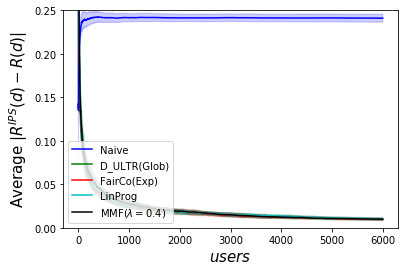

In [347]:
# fig = plt.figure(figsize=(5,2))
fig, ax = plt.subplots()
from brokenaxes import brokenaxes
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
# bax = brokenaxes( ylims=((0, .05), (.2, .25)), hspace=.05)
bax=ax
for dt_i in list_iter:
    mean_relevances=np.mean(data[dt_i]["aff_scores"],1,keepdims=True)
    popularity_hist=data[dt_i]["pophist"] if method[dt_i]=="Naive" else data[dt_i]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),\
               label=method[dt_i],color=None,ax=bax)
for i in range(2,6,4):
    mean_relevances=np.mean(data[i+4]["aff_scores"],1,keepdims=True)
    popularity_hist=data[i+4]["pophist"] if method[dt_i]=="Naive" else data[i+4]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0)\
               ,label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=bax)

    
# plt.legend()
# ax = plt.gca()
ax = bax
ax.legend(loc=3)
ax.set_ylim(0.0,.25)
ax.set_xlabel("$users$", fontsize=15)
ax.set_ylabel("Average $|R^{IPS}(d)-R(d)|$", fontsize=15)
plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/Relevance_convergence.pdf", bbox_inches="tight", dpi=800)
plt.show()
plt.close("all")

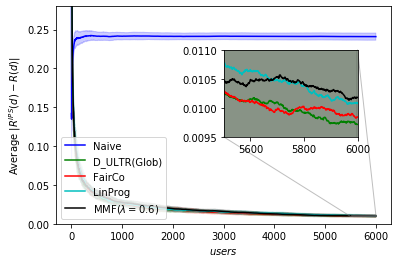

In [363]:
# fig = plt.figure(figsize=(5,2))
fig, ax = plt.subplots()
from brokenaxes import brokenaxes
method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
# bax = brokenaxes( ylims=((0, .05), (.2, .25)), hspace=.05)
bax=ax
for dt_i in list_iter:
    mean_relevances=np.mean(data[dt_i]["aff_scores"],1,keepdims=True)
    popularity_hist=data[dt_i]["pophist"] if method[dt_i]=="Naive" else data[dt_i]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),\
               label=method[dt_i],color=None,ax=bax)
for i in range(3,6,5):
    mean_relevances=np.mean(data[i+4]["aff_scores"],1,keepdims=True)
    popularity_hist=data[i+4]["pophist"] if method[dt_i]=="Naive" else data[i+4]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0)\
               ,label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=bax)

    
# plt.legend()
# ax = plt.gca()
ax = bax
ax.legend(loc=3)
ax.set_ylim(0.0,.28)
ax.set_xlabel("$users$", fontsize=10)
ax.set_ylabel("Average $|R^{IPS}(d)-R(d)|$", fontsize=10)



axins = ax.inset_axes([0.5, 0.4, 0.4, 0.4])
bax = axins
for dt_i in list_iter:
    mean_relevances=np.mean(data[dt_i]["aff_scores"],1,keepdims=True)
    popularity_hist=data[dt_i]["pophist"] if method[dt_i]=="Naive" else data[dt_i]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),\
               label=method[dt_i],color=None,ax=bax)
for i in range(3,6,5):
    mean_relevances=np.mean(data[i+4]["aff_scores"],1,keepdims=True)
    popularity_hist=data[i+4]["pophist"] if method[dt_i]=="Naive" else data[i+4]["w_pophist"]
    iterations=popularity_hist.shape[1]
    rel_estimate = popularity_hist / np.arange(1, iterations + 1)[ np.newaxis,:, np.newaxis]
    nd=np.mean(np.abs(rel_estimate-mean_relevances),-1)
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0)\
               ,label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=bax)



# sub region of the original image
x1, x2, y1, y2 = 5500, 6000, 0.0095, 0.011
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_xticklabels('')
# axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)





plt.savefig("plots/Asaved/batch_run_dataset1/figure/Relevance_convergence.pdf", bbox_inches="tight", dpi=600)
plt.show()
plt.close("all")

In [ ]:
shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="Fair_MMR($\lambda="+str(lamb[i])+"$)",color=None)


## From below graph, I thind I should use line plot without std shown.

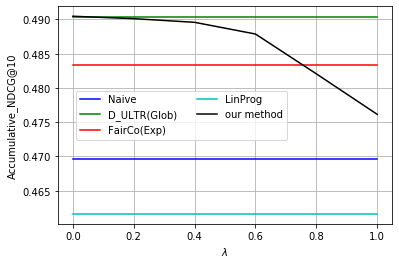

In [364]:
fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=10)
plt.ylabel("Accumulative_NDCG@10", fontsize=10)
plt.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)

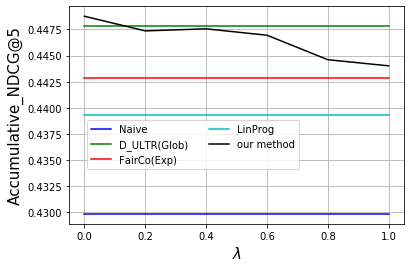

In [90]:
fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(dt_i["NDCG_5"])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(dt_i["NDCG_5"])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=15)
plt.ylabel("Accumulative_NDCG@5", fontsize=15)
plt.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
plt.savefig("plots/Asaved/batch_run_dataset1/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)

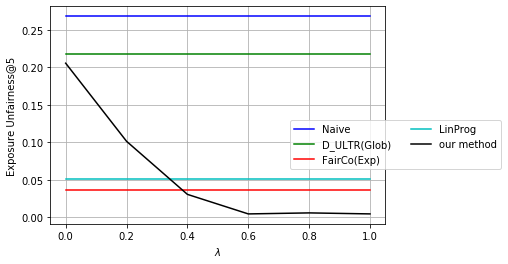

In [91]:
##Unfairness @5
fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][2])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][2])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=10)
plt.ylabel("Exposure Unfairness@5", fontsize=10)
plt.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))

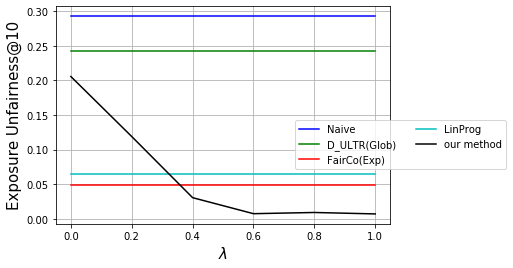

In [92]:
##Unfairness @10
fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][3])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][3])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=15)
plt.ylabel("Exposure Unfairness@10", fontsize=15)
plt.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))

In [119]:
## Then  we plot unfairness and ndcg @5

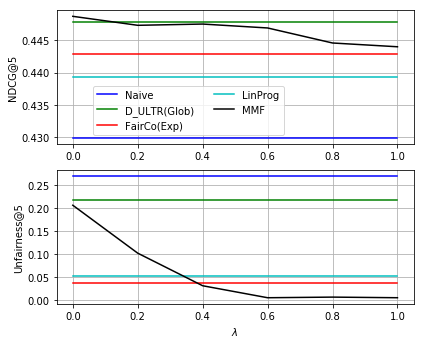

In [187]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_5"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_5"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
# ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("NDCG@5", fontsize=10)
ax.legend(ncol=2,bbox_to_anchor=(0.65,0.25))
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][2])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][2])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("Unfairness@5", fontsize=10)
ax.grid()

plt.savefig("plots/Asaved/batch_run_dataset1/figure/paper_5.4/comparison_ndcg_unfairness_at_5.pdf", bbox_inches="tight", dpi = 600)

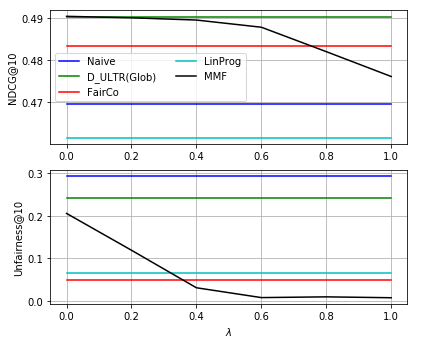

In [365]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
# ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("NDCG@10", fontsize=10)
ax.legend(ncol=2,loc=6)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][3])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][3])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("Unfairness@10", fontsize=10)
ax.grid()

plt.savefig("plots/Asaved/batch_run_dataset1/figure/paper_5.4/comparison_ndcg_unfairness_at_10.pdf", bbox_inches="tight", dpi = 600)

## Then I would like to plot for all top k.

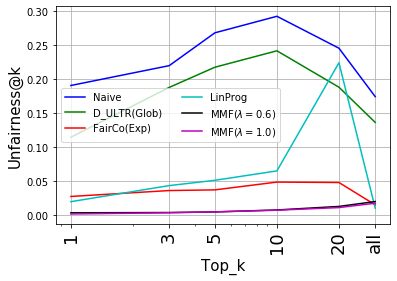

In [367]:
fig,ax = plt.subplots()
lamb=[0.0,0.2,0.4,0.6,0.8,1.0] 
top_k_list=[1,3,5,10,20,30]
x_ticks_labels=["1","3","5","10","20","all"]
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
for ind,i in enumerate(method):
    ax.plot(np.array(top_k_list),np.mean(data_unfairness_table[ind],1),label=method[ind])
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

for i in range(3,6,2):
    ax.plot(np.array(top_k_list),np.mean(data_unfairness_table[i+4],1),label="MMF($\lambda="+str(lamb[i])+"$)")
plt.xlabel("Top_k", fontsize=15)
plt.xscale("log")
plt.xticks(top_k_list)
plt.ylabel("Unfairness@k", fontsize=15)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.grid()
x_ticks_labels=["1","3","5","10","20","all"]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=10)
ax.legend(ncol=2)
plt.savefig("plots/Asaved/batch_run_dataset1/figure/comparison_all_lambda_FairE.pdf", bbox_inches="tight", dpi = 200)

In [160]:
## For news data ndcg is hard to see. So I will only keep the unfairness @top graph

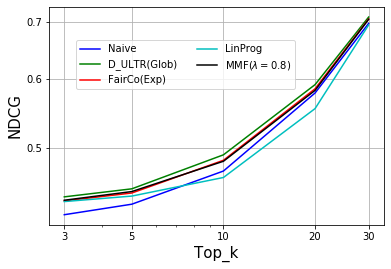

In [96]:
fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=[np.mean(dt_i["NDCG_"+str(i)])for i in top_k_list[1:]]
    
    ax.plot(top_k_list[1:],cur,label=method[ind])
    
for i in range(4,6,4):
    cur=[np.mean(data[i+4]["NDCG_"+str(top)])for top in top_k_list[1:]]
    ax.plot(np.array(top_k_list[1:]),cur,\
            label="MMF($\lambda="+str(lamb[i])+"$)")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG@5", fontsize=15)
# plt.grid()
# plt.xscale("log")
# plt.grid()
plt.xlabel("Top_k", fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.xticks(top_k_list[1:])
plt.yticks([0.5,0.6,0.7])
plt.ylabel("NDCG", fontsize=15)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.grid()

ax.legend(ncol=2,bbox_to_anchor=(0.75,0.6))
plt.savefig("plots/Asaved/batch_run_dataset1/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 600)




In [380]:
top_k_list[1:]

[3, 5, 10, 20, 30]

## Try to plot std, but hard to see performance clear after adding std

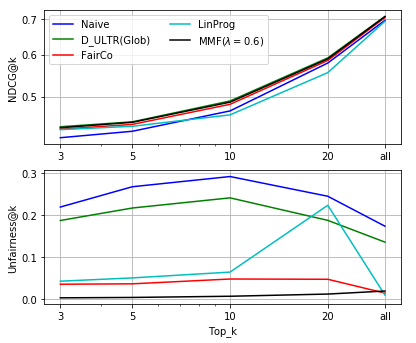

In [382]:
lamb=[0.0,0.2,0.4,0.6,0.8,1.0] 
top_k_list=[1,3,5,10,20,30]
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=[np.mean(dt_i["NDCG_"+str(i)])for i in top_k_list[1:]]
    
    ax.plot(top_k_list[1:],cur,label=method[ind])
    
for i in range(3,6,4):
    cur=[np.mean(data[i+4]["NDCG_"+str(top)])for top in top_k_list[1:]]
    ax.plot(np.array(top_k_list[1:]),cur,\
            label="MMF($\lambda="+str(lamb[i])+"$)")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG@5", fontsize=15)
# plt.grid()
# plt.xscale("log")
# plt.grid()
# ax.set_xlabel("Top_k", fontsize=10)

ax.set_ylabel("NDCG@k", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(top_k_list[1:])

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([0.5,0.6,0.7])
ax.legend(ncol=2)
x_ticks_labels=["3","5","10","20","all"]
ax.set_xticklabels(x_ticks_labels, fontsize=10)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
for ind,i in enumerate(method):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[ind][1:],1),label=method[ind])
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

for i in range(3,6,4):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="MMF($\lambda="+str(lamb[i])+"$)")
ax.set_xlabel("Top_k", fontsize=10)
ax.set_ylabel("Unfairness@k", fontsize=10)
ax.set_xscale("log")
# plt.yscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xticks(top_k_list[1:])
x_ticks_labels=["3","5","10","20","all"]
ax.set_xticklabels(x_ticks_labels, fontsize=10)
ax.grid()

plt.savefig("plots/Asaved/batch_run_dataset1/figure/paper_5.4/comparison_ndcg_unfairness_top_k.pdf", bbox_inches="tight", dpi = 600)

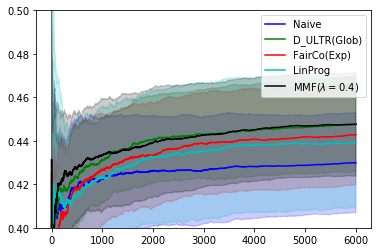

In [98]:
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None)

for i in range(2,6,4):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
plt.legend()
ax = plt.gca()
ax.set_ylim(0.4,.5)
plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
plt.show()
plt.close("all")

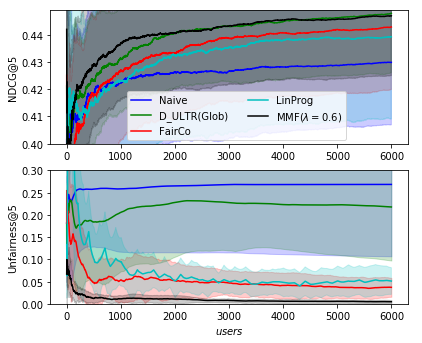

In [372]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None,ax=ax1)

for i in range(3,6,4):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax1)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
ax1.legend(ncol=2,bbox_to_anchor=(0.2,0.43))
# ax1.set_xlabel("$users$", fontsize=10)
ax1.set_ylabel("NDCG@5", fontsize=10)
ax1.set_ylim(0.4,.449)
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
# plt.show()
# plt.close("all")

method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
labels=method
for i, nd in enumerate(data_unfairness_table_all[:4]):
#     plot_ndcg(np.mean(nd[0], axis=0), label=labels[i], plot=False, window_size=100, std=nd[0])
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),label=labels[i],color=None,ax=ax2)
for i in range(3,6,4):
    nd=data_unfairness_table_all[i+4]
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),\
               label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax2)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
ax2.set_xlabel("$users$", fontsize=10)
ax2.set_ylabel("Unfairness@5", fontsize=10)
ax2.set_ylim(0.0,0.3)
# plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.savefig("plots/Asaved/batch_run_dataset1/figure/paper_5.4/convergence_at_5.pdf", bbox_inches="tight", dpi=800)

plt.show()
#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
plt.close("all")

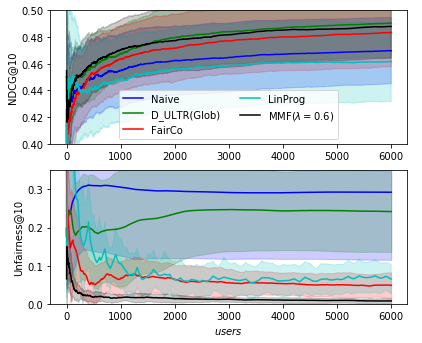

In [393]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_10"],1)/(np.arange(1,nd["NDCG_10"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None,ax=ax1)

for i in range(3,6,4):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_10"],1)/(np.arange(1,nd["NDCG_10"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax1)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
ax1.legend(ncol=2,loc=8)
# ax1.set_xlabel("$users$", fontsize=10)
ax1.set_ylabel("NDCG@10", fontsize=10)
ax1.set_ylim(0.4,.5)
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
# plt.show()
# plt.close("all")

method=["Naive", "D_ULTR(Glob)", "FairCo","LinProg"]
labels=method
for i, nd in enumerate(data_unfairness_table_all[:4]):
#     plot_ndcg(np.mean(nd[0], axis=0), label=labels[i], plot=False, window_size=100, std=nd[0])
    shaded_std(step=np.arange(nd[3].shape[-1]), mean=np.mean(nd[3], axis=0),std=np.std(nd[3], axis=0),label=labels[i],color=None,ax=ax2)
for i in range(3,6,4):
    nd=data_unfairness_table_all[i+4]
    shaded_std(step=np.arange(nd[3].shape[-1]), mean=np.mean(nd[3], axis=0),std=np.std(nd[3], axis=0),\
               label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax2)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
ax2.set_xlabel("$users$", fontsize=10)
ax2.set_ylabel("Unfairness@10", fontsize=10)
ax2.set_ylim(0.0,0.35)
# plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.savefig("plots/Asaved/batch_run_dataset1/figure/paper_5.4/convergence_at_10.pdf", bbox_inches="tight", dpi=800)

plt.show()
#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
plt.close("all")

In [64]:
num_g=[]
for j in range(len(data[1]["G"])):
    num_g.append([])
    num_g_cur=num_g[-1]
    for i in data[1]["G"][j]:
#         print(len(i))
        num_g_cur.append(len(i))
num_g=np.array(num_g)

In [167]:
accum_aver_exp=np.zeros((2,30))
rank_group_id_sorted=data[9]["rank_group_id_sorted"][0]
for i in range(rank_group_id_sorted.shape[0]):
    for G_i in range(2):
        ind_Gi=rank_group_id_sorted[i]==G_i
        exposure_cur=np.cumsum(ind_Gi*1*position_bias(30))
#         exposure_cur=np.cumsum(ind_Gi*1)
        exposure_aver=exposure_cur
#         print(ind_Gi,exposure_cur,np.cumsum(ind_Gi)+1e-10)
#         print(exposure_aver)
        accum_aver_exp[G_i]+=exposure_aver   
print(accum_aver_exp/np.sum(accum_aver_exp,0,keepdims=True))

[[0.61033333 0.61026886 0.61028399 0.61026426 0.61027332 0.61027979
  0.61026943 0.61027453 0.61027869 0.61027156 0.61027513 0.61027822
  0.61027275 0.61027551 0.61027798 0.6102802  0.61027591 0.61027796
  0.61027418 0.61027609 0.61027272 0.61026959 0.61025723 0.6102593
  0.61027432 0.61028001 0.60998936 0.60866133 0.60647787 0.60343058]
 [0.38966667 0.38973114 0.38971601 0.38973574 0.38972668 0.38972021
  0.38973057 0.38972547 0.38972131 0.38972844 0.38972487 0.38972178
  0.38972725 0.38972449 0.38972202 0.3897198  0.38972409 0.38972204
  0.38972582 0.38972391 0.38972728 0.38973041 0.38974277 0.3897407
  0.38972568 0.38971999 0.39001064 0.39133867 0.39352213 0.39656942]]


In [145]:
rank_group_id_sorted[0]

array([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.])

In [169]:
accum_aver_exp=np.zeros((2,30))
rank_group_id_sorted=data[2]["rank_group_id_sorted"][0]
for i in range(rank_group_id_sorted.shape[0]):
    for G_i in range(2):
        ind_Gi=rank_group_id_sorted[i]==G_i
        exposure_cur=np.cumsum(ind_Gi*1*position_bias(30))
#         exposure_cur=np.cumsum(ind_Gi*1)
        exposure_aver=exposure_cur
#         print(ind_Gi,exposure_cur,np.cumsum(ind_Gi)+1e-10)
#         print(exposure_aver)
        accum_aver_exp[G_i]+=exposure_aver   
print(accum_aver_exp/np.sum(accum_aver_exp,0,keepdims=True))

[[0.6095     0.66598051 0.66391244 0.66283433 0.65380291 0.64485969
  0.6387031  0.63473707 0.63154808 0.63006053 0.62840854 0.62606091
  0.62372016 0.62168028 0.61937648 0.61755169 0.61588065 0.61437066
  0.61250707 0.6117954  0.61204866 0.61258373 0.61402997 0.61476789
  0.61620853 0.61788819 0.62006429 0.62227267 0.62244464 0.60984716]
 [0.3905     0.33401949 0.33608756 0.33716567 0.34619709 0.35514031
  0.3612969  0.36526293 0.36845192 0.36993947 0.37159146 0.37393909
  0.37627984 0.37831972 0.38062352 0.38244831 0.38411935 0.38562934
  0.38749293 0.3882046  0.38795134 0.38741627 0.38597003 0.38523211
  0.38379147 0.38211181 0.37993571 0.37772733 0.37755536 0.39015284]]


In [158]:
print(relevance)

[0.60844056 0.39155944]


In [157]:
data[0]["rank_group_split"][0]

array([[0.000e+00, 3.000e+00, 5.000e+00, 1.580e+02, 3.150e+02, 5.633e+03,
        5.902e+03, 5.844e+03, 5.600e+03, 5.650e+03, 5.345e+03, 5.307e+03,
        4.955e+03, 2.436e+03, 4.599e+03, 1.809e+03, 5.666e+03, 5.582e+03,
        5.492e+03, 4.488e+03, 5.189e+03, 4.630e+03, 4.164e+03, 5.030e+03,
        2.631e+03, 1.455e+03, 3.480e+03, 5.608e+03, 9.180e+02, 1.060e+02],
       [6.000e+03, 5.997e+03, 5.995e+03, 5.842e+03, 5.685e+03, 3.670e+02,
        9.800e+01, 1.560e+02, 4.000e+02, 3.500e+02, 6.550e+02, 6.930e+02,
        1.045e+03, 3.564e+03, 1.401e+03, 4.191e+03, 3.340e+02, 4.180e+02,
        5.080e+02, 1.512e+03, 8.110e+02, 1.370e+03, 1.836e+03, 9.700e+02,
        3.369e+03, 4.545e+03, 2.520e+03, 3.920e+02, 5.082e+03, 5.894e+03]])

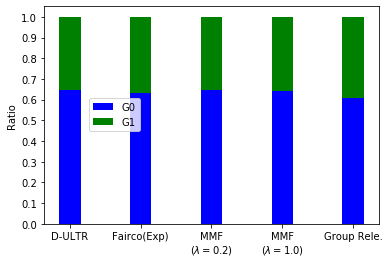

In [164]:
num_g=[]
for j in range(len(data[1]["G"])):
    num_g.append([])
    num_g_cur=num_g[-1]
    for i in data[1]["G"][j]:
#         print(len(i))
        num_g_cur.append(len(i))
num_g=np.array(num_g)
# relevance=data[0]["true_rel"][0,0,:]/num_g[0]
relevance=data[0]["true_rel"][0,0,:]
relevance=relevance/np.sum(relevance)
ind_ratio_plot=[2,3,7,9]
ratio_list=[]
for ind in ind_ratio_plot:
    ratio=data[ind]["rank_group_split"][1][:,0]/np.sum(data[ind]["rank_group_split"][1][:,0])
    ratio_list.append(ratio)
ratio_list.append(relevance)
ratio_list=np.array(ratio_list)
ratio_list=ratio_list.T
ind = np.arange(ratio_list.shape[1])
width = 0.3
p=[]
p.append( plt.bar(ind, ratio_list[0], width))
for i in range(1,ratio_list.shape[0]):
    p.append(plt.bar(ind, ratio_list[i], width,bottom=np.cumsum(ratio_list,0)[i-1]))

plt.ylabel('Ratio', fontsize=10)
# plt.title('Scores by group and gender')
plt.xticks(ind, ('D-ULTR', 'Fairco(Exp)', 'MMF\n($\lambda=0.2$)', 'MMF\n($\lambda=1.0$)', 'Group Rele.'),fontsize=10)
plt.yticks(np.arange(0, 11)/10)
plt.legend((p), ('G'+str(i) for i in range(5)),bbox_to_anchor=(0.3,0.6))

plt.savefig("plots/Asaved/batch_run_dataset1/figure/ratio.pdf", bbox_inches="tight", dpi = 600)
plt.show()

In [165]:
ratio_list

array([[0.64533333, 0.63316667, 0.646     , 0.64016667, 0.60844056],
       [0.35466667, 0.36683333, 0.354     , 0.35983333, 0.39155944]])

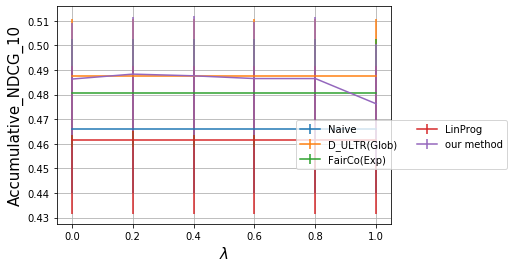

In [34]:
# # data=np.load("plots/Asaved/batch_run_dataset1_greedy/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data_lp=np.load("plots/Asaved/batch_run_dataset1_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data=np.append(data,data_lp[0])
# # lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
# # data_lambda=[]
# # for i in range(6):
# #     data_lambda.append(np.load("plots/Asaved/batch_run_dataset1_greedy/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True))
#     #### each of the data contain one lambda variant.
# cur_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std=np.std(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         cur_lambda_list.append(cur)
# # plt.plot(lamb,cur_lambda_list)
# fig, ax = plt.subplots()
# method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
# list_iter=[0,1,2,3]
# for dt_i in list_iter:
#     cur=np.mean(np.sum(data[dt_i]["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
#     std=np.std(np.sum(data[dt_i]["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
#     cur=[cur for i in range(len(lamb))]
#     std=[std for i in range(len(lamb))]
#     ax.errorbar(lamb,cur,std,label=method[dt_i])
# cur_lambda_list=[]
# std_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std=np.std(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std_lambda_list.append(std)
#         cur_lambda_list.append(cur)
# ax.errorbar(lamb,cur_lambda_list,std_lambda_list,label="our method")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG_10", fontsize=15)
# plt.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)

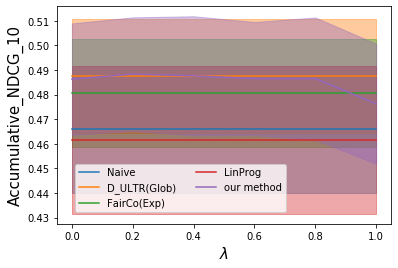

In [40]:
# # data=np.load("plots/Asaved/batch_run_dataset1_greedy/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data_lp=np.load("plots/Asaved/batch_run_dataset1_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data=np.append(data,data_lp[0])
# # lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
# # data_lambda=[]
# # for i in range(6):
# #     data_lambda.append(np.load("plots/Asaved/batch_run_dataset1_greedy/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True))
#     #### each of the data contain one lambda variant.
# cur_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std=np.std(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         cur_lambda_list.append(cur)
# # plt.plot(lamb,cur_lambda_list)
# fig, ax = plt.subplots()
# method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
# list_iter=[0,1,2,3]
# for dt_i in list_iter:
#     cur=np.mean(np.sum(data[dt_i]["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
#     std=np.std(np.sum(data[dt_i]["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
#     cur=[cur for i in range(len(lamb))]
#     std=[std for i in range(len(lamb))]
#     shaded_std(lamb,cur,std,label=method[dt_i])
# cur_lambda_list=[]
# std_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std=np.std(np.sum(j[0]["NDCG_10"],axis=1)/j[0]["NDCG"].shape[1])
#         std_lambda_list.append(std)
#         cur_lambda_list.append(cur)
# shaded_std(lamb,cur_lambda_list,std_lambda_list,label="our method",)
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG_10", fontsize=15)
# # plt.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.3))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)

In [74]:
# labels=["1","2"]
# methods=labels
# res_lp=plot_topk(top_k_list=[1,3,5,10,20,30],file="plots/Asaved/batch_run_dataset1/lp_E/Fairness_Data.npy",labels=labels,methods=labels)
# labels=["1","2","3","4"]
# methods=labels
# res_d1=plot_topk(top_k_list=[1,3,5,10,20,30],file="plots/Asaved/batch_run_dataset1/original/Fairness_Data.npy",labels=labels,methods=labels)
# lamb=[0.0,0.2,0.4,0.6,0.8,1.0]  ## this is to iterate all lambda for fairness plot
# data_lambda=[]
# labels=["1","2"]
# methods=labels
# unfair_result_d1=[]
# for i in range(6):
#     print(i)
#     unfair_result_d1.append(plot_topk(top_k_list=[1,3,5,10,20,30],file="plots/Asaved/batch_run_dataset1/top_down_"+str(lamb[i])+"/Fairness_Data.npy",labels=labels,methods=labels))

N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (15 of 15) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


In [84]:
res_d1[0].shape

(3, 20, 6000, 4)

In [85]:
# data_plot_unfairness={"lp":res_lp,"baseline":res_d1,"ours":unfair_result_d1}
# np.save("plots/Asaved/batch_run_dataset1/figure/plotdata.npy",data_plot_unfairness)

# data_plot_unfairness=np.load("plots/Asaved/batch_run_dataset1/figure/plotdata.npy",allow_pickle=True)
# res=data_plot_unfairness[()]['baseline']
# unfair_result=data_plot_unfairness[()]['ours']
# res_lp=data_plot_unfairness[()]['lp']

In [66]:
# data_plot_unfairness=np.load("plots/Asaved/batch_run_dataset1_greedy/figure/plotdata.npy",allow_pickle=True)
# res=data_plot_unfairness[()]['baseline']
# unfair_result=data_plot_unfairness[()]['ours']
# res_lp=data_plot_unfairness[()]['lp']
# top_method=[]
# lamb=[0.0,0.2,0.4,0.6,0.8,1.0] 
# top_k_list=[1,3,5,10,20,30]
# for i in range(len(top_k_list)):
#     top_method.append(np.mean(res[i][:,:,-1,0],1))   ## used for extract unfairness in baseline method

# top_method_lamb=[]
# for j in unfair_result:
#     top_method_lamb.append([])
#     top_method_lamb_cur=top_method_lamb[-1]
#     for i in range(len(top_k_list)):
#         top_method_lamb_cur.append(np.mean(j[i][0,:,-1,0],0)) ## used for extract unfairness in our method with differnet lambda
    
# top_method=np.array(top_method)    
# top_method_lamb=np.array(top_method_lamb)
# top_method_lamb=top_method_lamb.T
# top_lp_method=[]
# top_k_list=[1,3,5,10,20,30]
# for i in range(len(top_k_list)):
#     top_lp_method.append(np.mean(res_lp[i][:,:,-1,0],1))   ## used for extract unfairness in baseline method
# top_lp_method=np.array(top_lp_method)

ValueError: x and y must have same first dimension, but have shapes (4,) and (6,)

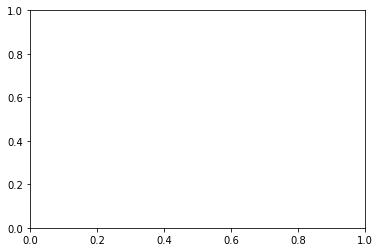

In [179]:
# fig,ax = plt.subplots()
# method=["LinProg"]
# ax.plot(np.array(top_k_list),top_lp_method[:,0],label=method[-1])
# method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)"]
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])
# # ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

# for i in range(0,6):
#     ax.plot(np.array(top_k_list),top_method_lamb[:,i],label="ours_$\lambda\_"+str(lamb[i])+"$")
# plt.xlabel("Top_k", fontsize=15)
# plt.xscale("log")
# plt.xticks(top_k_list)
# plt.ylabel("Unfairness", fontsize=15)
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.grid()
# ax.legend(ncol=2)
# plt.savefig("plots/Asaved/batch_run_dataset1/figure/comparison_all_lambda_FairE.pdf", bbox_inches="tight", dpi = 200)

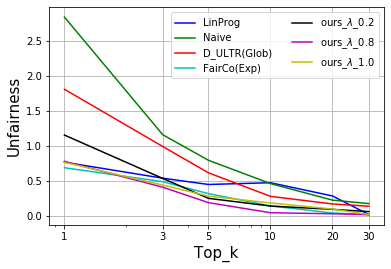

In [68]:

fig,ax = plt.subplots()
method=["LinProg"]
ax.plot(np.array(top_k_list),top_lp_method[:,0],label=method[-1])
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","ours_$\lambda$_0.0"]
list_=[0,1,2]
for i in list_:
    ax.plot(np.array(top_k_list),top_method[:,i],label=method[i])
# compare
# ax.plot(np.array(top_k_list),compare[:,0],label=method[1])

draw=[1,4,5]
for i in draw[0:]:
    ax.plot(np.array(top_k_list),top_method_lamb[:,i],label="ours_$\lambda$_"+str(lamb[i]))
plt.xlabel("Top_k", fontsize=15)
plt.xscale("log")
plt.xticks(top_k_list)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel("Unfairness", fontsize=15)
plt.grid(True)
ax.legend(ncol=2)
plt.savefig("plots/Asaved/batch_run_dataset1/figure/comparison_with_NA_IPS_Pers_FairE.pdf", bbox_inches="tight", dpi = 200)

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

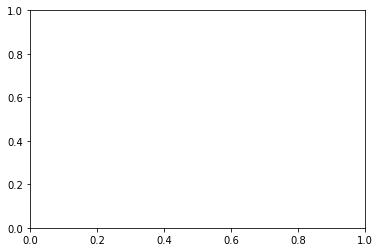

In [115]:
fig,ax = plt.subplots()
cur_lambda_list=[]
for j in data_lambda:
        cur=np.mean(np.sum(j[0]["NDCG"],axis=1)/j[0]["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="accumulative NDCG", color='red')
select_id=[0,2,3,5]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]  ## this is to iterate all lambda for fairness plot
top_k_list=[1,3,5,10,20,30]
dict_id_topk={}
for ind,top_k in enumerate(top_k_list):
    dict_id_topk[ind]=top_k
ax2 = ax.twinx()
color=["b","k","g","c"]
for ind in select_id:
    ax2.plot(lamb,-top_method_lamb[ind,:],label="Unfairness top_"+str(dict_id_topk[ind]), color=color.pop(0))
# plt.xlabel("$\lambda$", fontsize=15)
ax.set_xlabel("$\lambda$", fontsize=15)
plt.xticks(lamb)
ax.set_ylabel("Acumulative_NDCG", fontsize=15)
ax.tick_params(axis='y', colors='red')
ax2.set_ylabel("Negative unfairness", fontsize=15)

ax.legend(ncol=2,bbox_to_anchor=(0.7, 0.3))
ax2.legend(ncol=2)

ax.grid(True)
plt.savefig("plots/Asaved/batch_run_dataset1/figure/ndcg_fairness_tradeoff.pdf", bbox_inches="tight", dpi = 200)

## Prepare the table for the paper  on greedy method with dataset1.

## For dataset 1, we select 3,5,10,20,30.

## Top k of ndcg in dataset1

In [182]:
data=np.load("plots/Asaved/batch_run_dataset1/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
data_lp=np.load("plots/Asaved/batch_run_dataset1/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
data=np.append(data,data_lp[0])
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
data_lambda=[]
for i in range(6):
    data_lambda_cur=np.load("plots/Asaved/batch_run_dataset1/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True)
    data=np.append(data,data_lambda_cur[0])

data_plot_unfairness=np.load("plots/Asaved/batch_run_dataset1/figure/plotdata.npy",allow_pickle=True)
res=data_plot_unfairness[()]['baseline']
unfair_result=data_plot_unfairness[()]['ours']
res_lp=data_plot_unfairness[()]['lp']    
data_unfairness_table=[]
res_np=np.array(res)
res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(3):
    data_unfairness_table.append(res_np[:,i,:])
res_lp_np=np.array(res_lp)
res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
data_unfairness_table.append(res_lp_np)
print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table.append(unfair_result_np[i,:,:])    
    
    
    
method=["Naive", "D_ULTR(Glob)", "FairCo(Exp)","LinProg"]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for i in lamb:
    method.append("lambda_"+str(i))
top_k_list=[3,5,10,30]
dict_ket=["NDCG_"+str(i)for i in top_k_list]
top_k_list_orig=[1,3,5,10,20,30]
ind_table={}
for ind,i in enumerate(top_k_list_orig):
    ind_table[i]=ind
table=[]
dt_i_ind=[0,1,2,3,7]
for dt_i in range(10):
# for dt_i in dt_i_ind:
    print("*"*30)
    string=""
    table_cur=[]
    for keys in  dict_ket:
        
        ndcg_base=np.sum(data[2][keys],axis=1)/data[0][keys].shape[1]
        cur=np.sum(data[dt_i][keys],axis=1)/data[0][keys].shape[1]
        result=[1,1]
        if dt_i==3:
            ind_select=np.random.choice(ndcg_base.shape[0], cur.shape[0], replace=False)
            ndcg_base=ndcg_base[ind_select]
        result=stats.ttest_rel(ndcg_base,cur)
        table_cur.append([np.mean(cur),result[1]])
        print("current method",method[dt_i],keys)
        print(np.mean(cur),"mean",result,"significance with fairco")
        
    for top_k in  top_k_list:
        ind=ind_table[top_k]
        cur=data_unfairness_table[dt_i][ind]
        data_unfairness_base=data_unfairness_table[2][ind]
        result=[1,1]
        if dt_i==3:
            ind_select=np.random.choice(ndcg_base.shape[0], cur.shape[0], replace=False)
            data_unfairness_base=data_unfairness_base[ind_select]
        result=stats.ttest_rel(data_unfairness_base,cur)
        print("unfairness @",top_k)
        print(cur.mean(),result)
        table_cur.append([-np.mean(cur),result[1]])
    table.append(table_cur)
    print("*"*30)
table=np.array(table)

(6, 3, 20)
(6, 15)
(6, 6, 20)
******************************
current method Naive NDCG_3
0.4179594998544684 mean Ttest_relResult(statistic=3.379322205110503, pvalue=0.0031482669924024747) significance with fairco
current method Naive NDCG_5
0.4298572732758267 mean Ttest_relResult(statistic=2.861425818930378, pvalue=0.009989247132203324) significance with fairco
current method Naive NDCG_10
0.46964275328318755 mean Ttest_relResult(statistic=2.6157174628296955, pvalue=0.01700471427073227) significance with fairco
current method Naive NDCG_30
0.6965218246797078 mean Ttest_relResult(statistic=2.20236261244909, pvalue=0.04018916957777964) significance with fairco
unfairness @ 3
0.22001462024791013 Ttest_relResult(statistic=-6.398208755960717, pvalue=3.895209024988971e-06)
unfairness @ 5
0.2683939328234458 Ttest_relResult(statistic=-6.518594625751586, pvalue=3.038391730250671e-06)
unfairness @ 10
0.29272671626691205 Ttest_relResult(statistic=-5.915434888506387, pvalue=1.0749629355939916e-05)

## Then we format the output.

In [175]:
table.shape[1]

8

In [183]:
for i in range(table.shape[0]):
    string=""
    for j in range(table.shape[1]):
        string_cur="& "
        val=table[i,j,0] if j<table.shape[1]/2 else -table[i,j,0]
        if table[i,j,0]==np.max(table[:,j,0]):
            string_cur+="\\textbf{"+"{0:.3f}".format(val)+"}"
        else:
            string_cur+="{0:.3f}".format(val)
#         print(table[i,2,0],table[i,j,0])
        if table[i,j,1]<0.05:
            if table[2,j,0]<table[i,j,0]:
                string_cur+="$^+$"
            else:
                string_cur+="$^-$"
        string+=string_cur
    print(string)
    print("*"*20)

& 0.418$^-$& 0.430$^-$& 0.470$^-$& 0.697$^-$& 0.220$^-$& 0.268$^-$& 0.293$^-$& 0.174$^-$
********************
& 0.438$^+$& 0.448$^+$& 0.490$^+$& 0.708& 0.188$^-$& 0.218$^-$& 0.242$^-$& 0.136$^-$
********************
& 0.434& 0.443& 0.483& 0.705& 0.036& 0.037& 0.049& 0.015
********************
& 0.433& 0.439& 0.462& 0.694& 0.043& 0.051& 0.065& \textbf{0.010}
********************
& \textbf{0.439}$^+$& \textbf{0.449}$^+$& \textbf{0.490}$^+$& 0.709$^+$& 0.205$^-$& 0.206$^-$& 0.206$^-$& 0.134$^-$
********************
& 0.437& 0.447$^+$& 0.490$^+$& 0.709$^+$& 0.085$^-$& 0.102$^-$& 0.119$^-$& 0.060$^-$
********************
& 0.436& 0.448$^+$& 0.490$^+$& \textbf{0.709}$^+$& 0.033& 0.031& 0.031& 0.028
********************
& 0.436& 0.447$^+$& 0.488$^+$& 0.708& 0.004$^+$& \textbf{0.005}$^+$& 0.007$^+$& 0.020
********************
& 0.434& 0.445& 0.482& 0.704& 0.004$^+$& 0.006$^+$& 0.009$^+$& 0.016
********************
& 0.435& 0.444& 0.476$^-$& 0.703& \textbf{0.003}$^+$& 0.005$^+$& \textbf{0.007}$

In [114]:
"{0:.3f}".format(5.56)

'5.560'

## Then top k of unfairness

## On dataset 2.

In [191]:
# lamb=[0.0,0.2,0.4,0.6,0.8,1.0]  ## this is to iterate all lambda for fairness plot
# data_lambda=[]
# labels=["1","2"]
# methods=labels
# unfair_result_d2=[]
# for i in range(6):
#     unfair_result_d2.append(plot_topk(top_k_list=[1,3,5,10,20,30,50,70,100],file="plots/Asaved/batch_run/top_down_"+str(lamb[i])+"/Fairness_Data.npy",labels=labels,methods=labels))

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


In [198]:
# labels=["1","2","3","4"]
# methods=labels
# res_d2=plot_topk(top_k_list=[1,3,5,10,20,30,50,70,100],file="plots/Asaved/batch_run/original/Fairness_Data.npy",labels=labels,methods=labels)


N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

5 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

10 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

20 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

50 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

50 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

50 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:15 Time:  0:00:15
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

70 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

70 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

70 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

100 1 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

100 2 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

100 3 current top_k,meth


100% (10 of 10) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


In [199]:
# data_plot_unfairness={"baseline":res_d2,"ours":unfair_result_d2}
# np.save("plots/Asaved/batch_run/figure/plotdata.npy",data_plot_unfairness)
# data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/plotdata.npy",allow_pickle=True)
# res=data_plot_unfairness[()]['baseline']
# unfair_result=data_plot_unfairness[()]['ours']

In [383]:
#ndcg performance
data=np.load("plots/Asaved/batch_run/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data_lp=np.load("plots/Asaved/batch_run_dataset2_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data=np.append(data,data_lp[0])
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
data_lambda=[]
for i in range(6):
    data_lambda_cur=np.load("plots/Asaved/batch_run/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True)
    data=np.append(data,data_lambda_cur[0])
    
    
##fairness performance
data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/plotdata.npy",allow_pickle=True)
res=data_plot_unfairness[()]['baseline']
unfair_result=data_plot_unfairness[()]['ours'] 
data_unfairness_table=[]
res_np=np.array(res)
res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(4):
    data_unfairness_table.append(res_np[:,i,:])
# res_lp_np=np.array(res_lp)
# res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# data_unfairness_table.append(res_lp_np)
# print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table.append(unfair_result_np[i,:,:])   
unfair_result_np=np.array(unfair_result)
data_unfairness_table_all=[]
res=np.array(res)
# res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(4):
    data_unfairness_table_all.append(res[:,i,:,:,0])
res_lp_np=np.array(res_lp)

# res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# data_unfairness_table_all.append(res_lp_np[:,0,:,:,0])
print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
# unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table_all.append(unfair_result_np[i,:,0,:,:,0])  

(9, 4, 10)
(6, 9, 5)
(9, 4, 10)
(6, 2, 15, 6000, 4)
(6, 9, 2, 5, 6000, 4)


In [197]:
data[0].keys()

dict_keys(['prop', 'clicks', 'rel', 'true_rel', 'NDCG', 'aff_scores', 'pophist', 'hist', 'w_pophist', 'propensity_history', 'G', 'rank_hist', 'numerical_relevance', 'rank_group_id_sorted', 'rank_group_split', 'rank_group_split_click'])

In [46]:
len(data_unfairness_table_all)

10

0
1
2
3


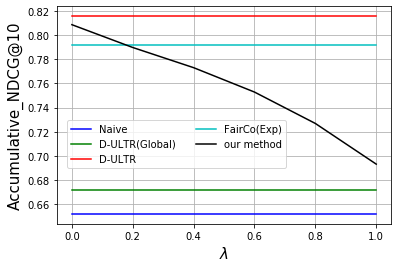

In [201]:
fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    print(ind)
    cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=15)
plt.ylabel("Accumulative_NDCG@10", fontsize=15)
plt.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
plt.savefig("plots/Asaved/batch_run_dataset2_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)

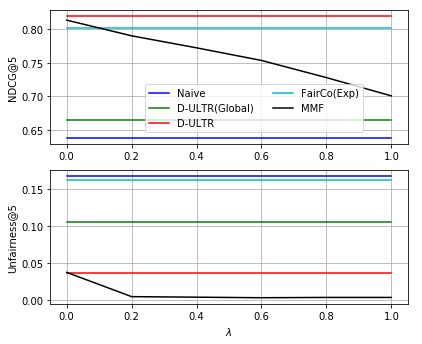

In [203]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_5"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_5"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
# ax.set_xlabel("$\lambda$", fontsize=15)
ax.set_ylabel("NDCG@5", fontsize=10)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][2])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][2])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("Unfairness@5", fontsize=10)
ax.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.25,1.25))
plt.savefig("plots/Asaved/batch_run/figure/paper_5.4/comparison_ndcg_unfairness_at_5.pdf", bbox_inches="tight", dpi = 600)

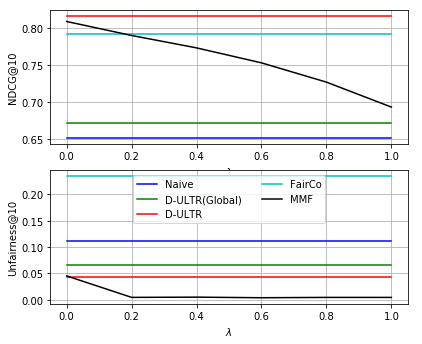

In [385]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("NDCG@10", fontsize=10)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][3])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][3])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
ax.set_xlabel("$\lambda$", fontsize=10)
ax.set_ylabel("Unfairness@10", fontsize=10)
ax.grid()
ax.legend(ncol=2,loc=9)
plt.savefig("plots/Asaved/batch_run/figure/paper_5.4/comparison_ndcg_unfairness_at_10.pdf", bbox_inches="tight", dpi = 600)

In [45]:
len(data_unfairness_table)

10

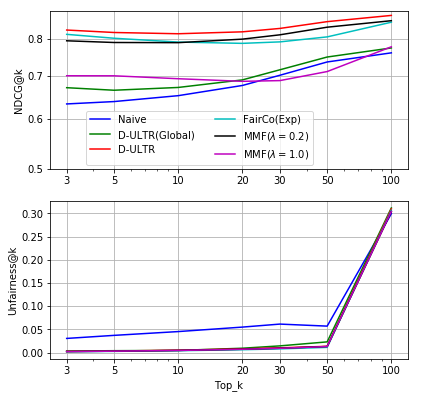

In [248]:
top_k_list=[1,3,5,10,20,30,50,100]
top_k_list_in_unfairness=[0,1,2,3,4,5,6,8]
fig = plt.figure(figsize=[6.4,6.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=[np.mean(dt_i["NDCG_"+str(i)])for i in top_k_list[1:]]
    
    ax.plot(top_k_list[1:],cur,label=method[ind])
    
for i in range(1,6,4):
    cur=[np.mean(data[i+4]["NDCG_"+str(top)])for top in top_k_list[1:]]
    ax.plot(np.array(top_k_list[1:]),cur,\
            label="MMF($\lambda="+str(lamb[i])+"$)")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG@5", fontsize=15)
# plt.grid()
# plt.xscale("log")
# plt.grid()
# ax.set_xlabel("Top_k", fontsize=10)

ax.set_ylabel("NDCG@k", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(top_k_list[1:])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([0.5,0.6,0.7,0.8])
ax.legend(ncol=2,bbox_to_anchor=(0.75,0.4))

ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
for ind,i in enumerate(method):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[ind][top_k_list_in_unfairness[1:]],1),label=method[ind])
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

for i in range(1,6,4):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][top_k_list_in_unfairness[1:]],1),label="MMF($\lambda="+str(lamb[i])+"$)")
ax.set_xlabel("Top_k", fontsize=10)
ax.set_ylabel("Unfairness@k", fontsize=10)
ax.set_xscale("log")
# plt.yscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# ax.set_yticks([0.0,1.0,2.0,3.0])
ax.set_xticks(top_k_list[1:])
ax.grid()
plt.savefig("plots/Asaved/batch_run_dataset2_greedy/figure/comparison_ndcg_unfairness_top_k.pdf", bbox_inches="tight", dpi = 600)

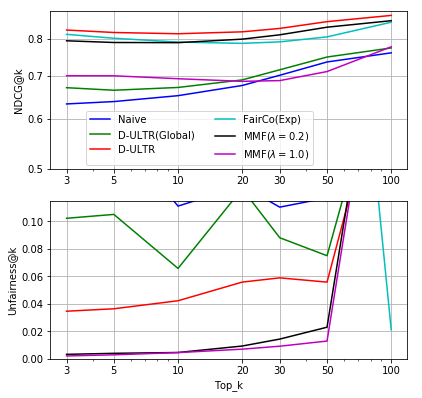

In [260]:
top_k_list=[1,3,5,10,20,30,50,100]
top_k_list_in_unfairness=[0,1,2,3,4,5,6,8]
fig = plt.figure(figsize=[6.4,6.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=[np.mean(dt_i["NDCG_"+str(i)])for i in top_k_list[1:]]
    
    ax.plot(top_k_list[1:],cur,label=method[ind])
    
for i in range(1,6,4):
    cur=[np.mean(data[i+4]["NDCG_"+str(top)])for top in top_k_list[1:]]
    ax.plot(np.array(top_k_list[1:]),cur,\
            label="MMF($\lambda="+str(lamb[i])+"$)")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG@5", fontsize=15)
# plt.grid()
# plt.xscale("log")
# plt.grid()
# ax.set_xlabel("Top_k", fontsize=10)

ax.set_ylabel("NDCG@k", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(top_k_list[1:])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([0.5,0.6,0.7,0.8])
ax.legend(ncol=2,bbox_to_anchor=(0.75,0.4))

ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
for ind,i in enumerate(method):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[ind][top_k_list_in_unfairness[1:]],1),label=method[ind])
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

for i in range(1,6,4):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][top_k_list_in_unfairness[1:]],1),label="MMF($\lambda="+str(lamb[i])+"$)")
ax.set_xlabel("Top_k", fontsize=10)
ax.set_ylabel("Unfairness@k", fontsize=10)
ax.set_xscale("log")
# plt.yscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylim(0,0.115)
# ax.set_yticks([0.0,1.0,2.0,3.0])
ax.set_xticks(top_k_list[1:])
ax.grid()
plt.savefig("plots/Asaved/batch_run_dataset2_greedy/figure/comparison_ndcg_unfairness_top_k.pdf", bbox_inches="tight", dpi = 600)

In [208]:
data_skyline=np.load("plots/Asaved/batch_run_dataset22_greedy/skyline/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method


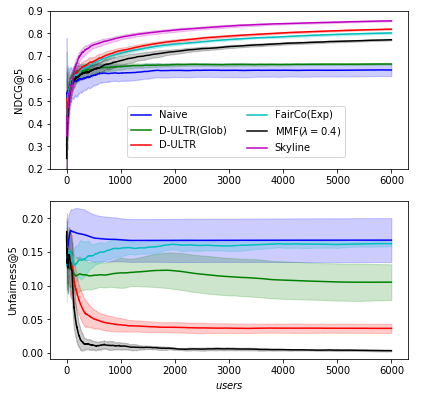

In [211]:
fig = plt.figure(figsize=[6.4,6.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None,ax=ax1)

for i in range(2,6,6):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax1)
nd=data_skyline[0]
nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="Skyline",color=None,ax=ax1)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
ax1.legend(ncol=2,bbox_to_anchor=(0.2,0.43))
# ax1.set_xlabel("$users$", fontsize=15)
ax1.set_ylabel("NDCG@5", fontsize=10)
ax1.set_ylim(0.2,0.9)
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
# plt.show()
# plt.close("all")

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
labels=method
for i, nd in enumerate(data_unfairness_table_all[:4]):
#     plot_ndcg(np.mean(nd[0], axis=0), label=labels[i], plot=False, window_size=100, std=nd[0])
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),label=labels[i],color=None,ax=ax2)
for i in range(2,6,6):
    nd=data_unfairness_table_all[i+4]
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),\
               label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax2)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
ax2.set_xlabel("$users$", fontsize=10)
ax2.set_ylabel("Unfairness@5", fontsize=10)
# ax2.set_ylim(0.1,2.6)
# plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.savefig("plots/Asaved/batch_run/figure/convergence_at_5.pdf", bbox_inches="tight", dpi=800)

plt.show()
#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
plt.close("all")

IndexError: list index out of range

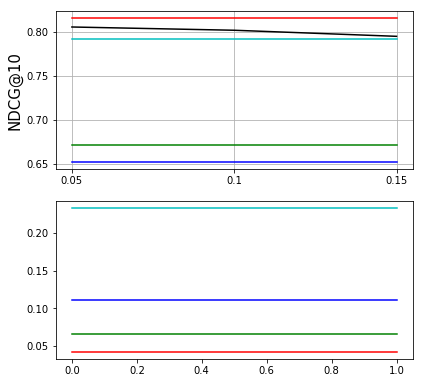

In [340]:
fig = plt.figure(figsize=[6.4,6.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[ind])
cur_lambda_list=[]
for dt_i in data[4:]:
        cur=np.mean(np.sum(dt_i["NDCG_10"],axis=1)/dt_i["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
# ax.set_xlabel("$\lambda$", fontsize=15)
ax.set_ylabel("NDCG@10", fontsize=15)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
list_iter=[0,1,2,3]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for dt_i in list_iter:
    cur=np.mean(data_unfairness_table[dt_i][3])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in range(4,10):
        cur=np.mean(data_unfairness_table[j][3])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="MMF")
ax.set_xlabel("$\lambda$", fontsize=15)
ax.set_ylabel("Unfairness@10", fontsize=15)
ax.grid()
ax.legend(ncol=2,bbox_to_anchor=(0.25,1.25))
plt.savefig("plots/Asaved/batch_run/figure/comparison_ndcg_unfairness_at_10.pdf", bbox_inches="tight", dpi = 600)

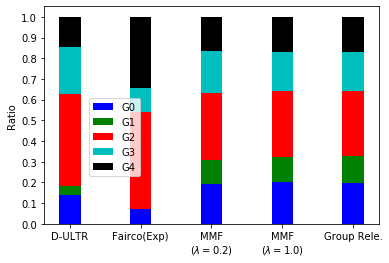

In [214]:
num_g=[]
for j in range(len(data[1]["G"])):
    num_g.append([])
    num_g_cur=num_g[-1]
    for i in data[1]["G"][j]:
#         print(len(i))
        num_g_cur.append(len(i))
num_g=np.array(num_g)
relevance=data[0]["true_rel"][0,0,:]
relevance=relevance/np.sum(relevance)
ind_ratio_plot=[2,3,5,9]
ratio_list=[]
for ind in ind_ratio_plot:
    ratio=data[ind]["rank_group_split"][0][:,0]/np.sum(data[2]["rank_group_split"][0][:,0])
    ratio_list.append(ratio)
ratio_list.append(relevance)
ratio_list=np.array(ratio_list)
ratio_list=ratio_list.T
ind = np.arange(ratio_list.shape[1])
width = 0.3
p=[]
p.append( plt.bar(ind, ratio_list[0], width))
for i in range(1,ratio_list.shape[0]):
    p.append(plt.bar(ind, ratio_list[i], width,bottom=np.cumsum(ratio_list,0)[i-1]))

plt.ylabel('Ratio', fontsize=10)
# plt.title('Scores by group and gender')
plt.xticks(ind, ('D-ULTR', 'Fairco(Exp)', 'MMF\n($\lambda=0.2$)', 'MMF\n($\lambda=1.0$)', 'Group Rele.'),fontsize=10)
plt.yticks(np.arange(0, 11)/10)
plt.legend((p), ('G'+str(i) for i in range(5)),bbox_to_anchor=(0.3,0.6))

plt.savefig("plots/Asaved/batch_run_dataset2_greedy/figure/ratio.pdf", bbox_inches="tight", dpi = 600)
plt.show()

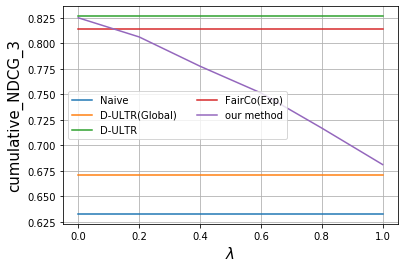

In [221]:
# prefix="plots/Asaved/batch_run_dataset2_greedy"
# data=np.load(prefix+"/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
# data_lambda=[]
# for i in range(6):
#     data_lambda.append(np.load(prefix+"/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True))
#     #### each of the data contain one lambda variant.
# cur_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_3"],axis=1)/j[0]["NDCG"].shape[1])
#         cur_lambda_list.append(cur)
# # plt.plot(lamb,cur_lambda_list)
# fig, ax = plt.subplots()
# method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
# for dt_i in range(len(data)):
#     cur=np.mean(np.sum(data[dt_i]["NDCG_3"],axis=1)/data[0]["NDCG"].shape[1])
#     cur=[cur for i in range(len(lamb))]
#     ax.plot(lamb,cur,label=method[dt_i])
# cur_lambda_list=[]
# for j in data_lambda:
#         cur=np.mean(np.sum(j[0]["NDCG_3"],axis=1)/j[0]["NDCG"].shape[1])
#         cur_lambda_list.append(cur)
# ax.plot(lamb,cur_lambda_list,label="our method")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("cumulative_NDCG_3", fontsize=15)
# ax.grid(True)
# ax.legend(ncol=2)
# plt.savefig(prefix+"/figure/comparison_cumulative_ndcg.pdf")

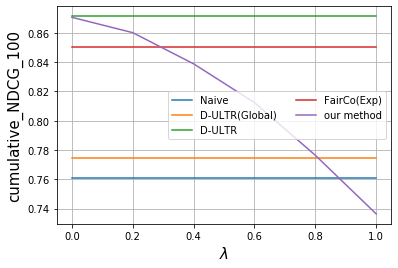

In [233]:
prefix="plots/Asaved/batch_run_dataset2_greedy"
data=np.load(prefix+"/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
data_lambda=[]
for i in range(6):
    data_lambda.append(np.load(prefix+"/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True))
    #### each of the data contain one lambda variant.
cur_lambda_list=[]
for j in data_lambda:
        cur=np.mean(np.sum(j[0]["NDCG_3"],axis=1)/j[0]["NDCG"].shape[1])
        cur_lambda_list.append(cur)
# plt.plot(lamb,cur_lambda_list)
fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
for dt_i in range(len(data)):
    cur=np.mean(np.sum(data[dt_i]["NDCG_100"],axis=1)/data[0]["NDCG"].shape[1])
    cur=[cur for i in range(len(lamb))]
    ax.plot(lamb,cur,label=method[dt_i])
cur_lambda_list=[]
for j in data_lambda:
        cur=np.mean(np.sum(j[0]["NDCG_100"],axis=1)/j[0]["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="our method")
plt.xlabel("$\lambda$", fontsize=15)
plt.ylabel("cumulative_NDCG_100", fontsize=15)
ax.grid(True)
ax.legend(ncol=2)
plt.savefig(prefix+"/figure/comparison_cumulative_ndcg.pdf")

IndexError: list index out of range

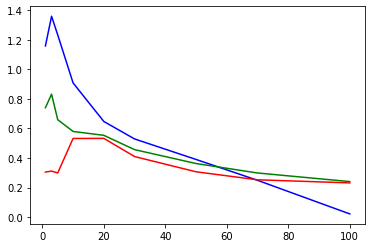

In [246]:
top_method=[]
top_k_list=[1,3,5,10,20,30,50,70,100]
for i in range(len(top_k_list)):
    top_method.append(np.mean(res[i][:,:,-1,0],1))   ## used for extract unfairness in baseline method
top_method_lamb=[]
for j in unfair_result:
    top_method_lamb.append([])
    top_method_lamb_cur=top_method_lamb[-1]
    for i in range(len(top_k_list)):
        top_method_lamb_cur.append(np.mean(j[i][0,:,-1,0],0)) ## used for extract unfairness in our method with differnet lambda
    
top_method=np.array(top_method) 
top_method_lamb=np.array(top_method_lamb)
top_method_lamb=top_method_lamb.T
fig,ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]

ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])
for i in range(6):
    ax.plot(np.array(top_k_list),top_method_lamb[:,i],label="ours_$\lambda\_"+str(lamb[i])+"$")
plt.xlabel("Top_k", fontsize=15)
plt.xscale("log")
plt.ylabel("Unfairness", fontsize=15)
plt.xticks(top_k_list)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.grid()
ax.legend(ncol=2)
plt.savefig(prefix+"/figure/comparison_all_lambda_FairE.pdf", bbox_inches="tight", dpi = 200)

ValueError: x and y must have same first dimension, but have shapes (4,) and (6,)

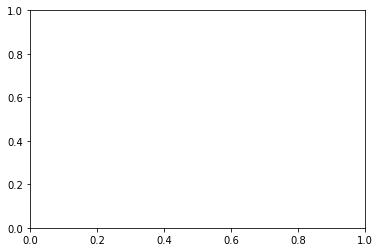

In [227]:
fig,ax = plt.subplots()
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
for i in range(4):
    ax.plot(np.array(top_k_list),top_method[:,i],label=method[i])
draw=[0,3,5]
for i in draw:
    ax.plot(np.array(top_k_list),top_method_lamb[:,i],label="ours_$\lambda\_"+str(lamb[i])+"$")
plt.xlabel("Top_k", fontsize=15)
plt.xscale("log")
plt.ylabel("Unfairness", fontsize=15)
plt.xticks(top_k_list)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.grid()
ax.legend(ncol=2)
plt.savefig(prefix+"/figure/comparison_with_NA_IPS_Pers_FairE.pdf", bbox_inches="tight", dpi = 200)

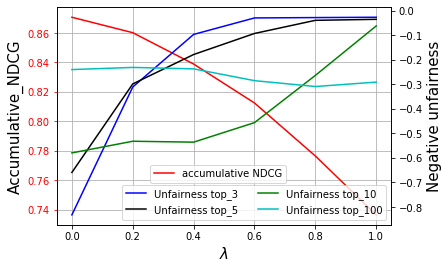

In [224]:
top_k_list=[1,3,5,10,20,30,50,70,100]
dict_id_topk={}
for ind,top_k in enumerate(top_k_list):
    dict_id_topk[ind]=top_k
fig,ax = plt.subplots()
cur_lambda_list=[]
for j in data_lambda:
        cur=np.mean(np.sum(j[0]["NDCG"],axis=1)/j[0]["NDCG"].shape[1])
        cur_lambda_list.append(cur)
ax.plot(lamb,cur_lambda_list,label="accumulative NDCG", color='red')
select_id=[1,2,3,8]

ax2 = ax.twinx()
color=["b","k","g","c","y"]
for ind in select_id:
    ax2.plot(lamb,-top_method_lamb[ind,:],label="Unfairness top_"+str(dict_id_topk[ind]), color=color.pop(0))
ax.set_xlabel("$\lambda$", fontsize=15)
ax.set_ylabel("Accumulative_NDCG", fontsize=15)
ax.tick_params(axis='y', colors='red')
ax2.set_ylabel("Negative unfairness", fontsize=15)

ax.legend(ncol=2,bbox_to_anchor=(0.7, 0.3))
ax2.legend(ncol=2)
ax.grid()
# plt.grid()
plt.savefig(prefix+"/figure/ndcg_fairness_tradeoff.pdf", bbox_inches="tight", dpi = 200)

## Then I try to plot top k ndcg? 

## This is on dataset2, the movie datasets.

In [169]:
def get_ndcg_score_top_k(ranking, true_relevances, click_model = "PBM_log",top_k_list=[1,3]):
    ndcg_top_k=[]
    for i in top_k_list:
#         print(true_relevances[ranking])
        dcg = np.sum(true_relevances[ranking][:i] / np.log2(2+np.arange(len(ranking)))[:i])
        idcg = np.sum(np.sort(true_relevances)[::-1][:i] / np.log2(2+np.arange(len(ranking)))[:i])
        if dcg is None or idcg is None or dcg/idcg is None:
            print("Some kind of None appeard with",dcg, idcg, dcg/idcg)
        if(idcg ==0):
            ndcg_top_k.append(1)
        else:
            ndcg_top_k.append(dcg / idcg)
    ndcg_top_k=np.array(ndcg_top_k)
    return ndcg_top_k

## Here, we decide to plot top metrics table for dataset 2

In [225]:
data=np.load("plots/Asaved/batch_run/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data_lp=np.load("plots/Asaved/batch_run_dataset2_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data=np.append(data,data_lp[0])
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
data_lambda=[]
for i in range(6):
    data_lambda_cur=np.load("plots/Asaved/batch_run/top_down_"+str(lamb[i])+"/Fairness_Data.npy", allow_pickle=True)
    data=np.append(data,data_lambda_cur[0])

data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/plotdata.npy",allow_pickle=True)
res=data_plot_unfairness[()]['baseline']
unfair_result=data_plot_unfairness[()]['ours']
# res_lp=data_plot_unfairness[()]['lp']    
data_unfairness_table=[]
res_np=np.array(res)
res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(4):
    data_unfairness_table.append(res_np[:,i,:])
# res_lp_np=np.array(res_lp)
# res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# data_unfairness_table.append(res_lp_np)
# print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(6):
    data_unfairness_table.append(unfair_result_np[i,:,:])    
    
    
    
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
lamb=[0.0,0.2,0.4,0.6,0.8,1.0]
for i in lamb:
    method.append("lambda_"+str(i))
top_k_list=[3,5,10,100]
dict_ket=["NDCG_"+str(i)for i in top_k_list]
top_k_list_orig=[1,3,5,10,20,30,50,70,100]
ind_table={}
for ind,i in enumerate(top_k_list_orig):
    ind_table[i]=ind
table=[]
for dt_i in range(10):
    print("*"*30)
    string=""
    table_cur=[]
    for keys in  dict_ket:
        
        ndcg_base=np.sum(data[3][keys],axis=1)/data[0][keys].shape[1]
        cur=np.sum(data[dt_i][keys],axis=1)/data[0][keys].shape[1]
        result=[1,1]
        if dt_i!=3:
            result=stats.ttest_rel(ndcg_base[:cur.shape[0]],cur)
        table_cur.append([np.mean(cur),result[1]])
        print("current method",method[dt_i],keys)
        print(np.mean(cur),"mean",result,"significance with fairco")
        
    for top_k in  top_k_list:
        ind=ind_table[top_k]
        cur=data_unfairness_table[dt_i][ind]
        data_unfairness_base=data_unfairness_table[3][ind]
        result=[1,1]
        if dt_i!=3:
            result=stats.ttest_rel(data_unfairness_base[:cur.shape[0]],cur)
        print("unfairness @",top_k)
        print(cur.mean(),result)
        table_cur.append([-np.mean(cur),result[1]])
    table.append(table_cur)
    print("*"*30)
table=np.array(table)

(9, 4, 10)
(6, 9, 5)
******************************
current method Naive NDCG_3
0.6328274966847742 mean Ttest_relResult(statistic=13.304321906635982, pvalue=3.182665049727907e-07) significance with fairco
current method Naive NDCG_5
0.6382626803500979 mean Ttest_relResult(statistic=17.03302597182057, pvalue=3.723542797813731e-08) significance with fairco
current method Naive NDCG_10
0.652014594172212 mean Ttest_relResult(statistic=18.42535184247424, pvalue=1.8691076210018907e-08) significance with fairco
current method Naive NDCG_100
0.7611484542804818 mean Ttest_relResult(statistic=16.68756641188811, pvalue=4.4546115112794495e-08) significance with fairco
unfairness @ 3
0.16615778167832573 Ttest_relResult(statistic=-8.221995337665868, pvalue=1.777539843780758e-05)
unfairness @ 5
0.16751637515878798 Ttest_relResult(statistic=-0.47163792688361866, pvalue=0.6484094998030898)
unfairness @ 10
0.11111885833038082 Ttest_relResult(statistic=12.536649217266373, pvalue=5.299891311296758e-07)
un

In [222]:
data_unfairness_base.shape

(10,)

In [223]:
cur.shape

(5,)

In [220]:
ind_table

{1: 0, 3: 1, 5: 2, 10: 3, 20: 4, 30: 5, 50: 6, 70: 7, 100: 8}

In [226]:
for i in range(table.shape[0]):
    string=""
    for j in range(table.shape[1]):
        string_cur="& "
        if table[i,j,0]==np.max(table[:,j,0]):
            string_cur+="\\textbf{"+"{0:.3f}".format(table[i,j,0])+"}"
        else:
            string_cur+="{0:.3f}".format(table[i,j,0])
#         print(table[i,2,0],table[i,j,0])
        if table[i,j,1]<0.05:
            if table[3,j,0]<table[i,j,0]:
                string_cur+="$^+$"
            else:
                string_cur+="$^-$"
        string+=string_cur
    print(string)
    print("*"*20)

& 0.633$^-$& 0.638$^-$& 0.652$^-$& 0.761$^-$& -0.166$^-$& -0.168& -0.111$^+$& -0.265$^-$
********************
& 0.671$^-$& 0.665$^-$& 0.672$^-$& 0.775$^-$& -0.102$^+$& -0.105$^+$& -0.066$^+$& -0.243$^-$
********************
& \textbf{0.827}$^+$& \textbf{0.819}$^+$& \textbf{0.816}$^+$& \textbf{0.871}$^+$& -0.035$^+$& -0.036$^+$& -0.042$^+$& -0.232$^-$
********************
& 0.814& 0.802& 0.791& 0.850& -0.123& -0.162& -0.234& \textbf{-0.021}
********************
& 0.823$^+$& 0.814$^+$& 0.809$^+$& 0.869$^+$& -0.030$^+$& -0.037$^+$& -0.045$^+$& -0.299$^-$
********************
& 0.795$^-$& 0.790$^-$& 0.790& 0.855$^+$& -0.003$^+$& -0.004$^+$& -0.005$^+$& -0.312$^-$
********************
& 0.774$^-$& 0.772$^-$& 0.773$^-$& 0.842$^-$& -0.002$^+$& -0.003$^+$& -0.005$^+$& -0.310$^-$
********************
& 0.754$^-$& 0.753$^-$& 0.753$^-$& 0.826$^-$& \textbf{-0.002}$^+$& \textbf{-0.003}$^+$& \textbf{-0.004}$^+$& -0.307$^-$
********************
& 0.727$^-$& 0.728$^-$& 0.727$^-$& 0.806$^-$& -0.002$^+$

# Below is the code for tuning $\lambda$ for dataset2

In [233]:
lamb=[0.05,0.1,0.15]  ## this is to iterate all lambda for fairness plot
data_lambda=[]
labels=["1","2"]
methods=labels
unfair_result_d2_tune=[]
for i in range(3):
    unfair_result_d2_tune.append(plot_topk(top_k_list=[1,3,5,10,20,30,50,70,100],file="plots/Asaved/batch_run/top_down_"+str(lamb[i])+"/Fairness_Data.npy",labels=labels,methods=labels))

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

1 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

3 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

5 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

10 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

20 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

30 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

50 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

70 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

100 0 current top_k,meth


100% (5 of 5) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [234]:
# data_plot_unfairness={"ours":unfair_result_d2_tune,"baseline":res}
# np.save("plots/Asaved/batch_run/figure/tune_0.05_0.1_0.15data.npy",data_plot_unfairness)

In [386]:
#ndcg performance
data=np.load("plots/Asaved/batch_run/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data_lp=np.load("plots/Asaved/batch_run_dataset2_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# data=np.append(data,data_lp[0])
lamb=["0.05","0.1","0.15"]
data_lambda=[]
for i in lamb:
    data_lambda_cur=np.load("plots/Asaved/batch_run/top_down_"+i+"/Fairness_Data.npy", allow_pickle=True)
    data=np.append(data,data_lambda_cur[0])
    
    
##fairness performance
data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/tune_0.05_0.1_0.15data.npy",allow_pickle=True)
res=data_plot_unfairness[()]['baseline']
unfair_result=data_plot_unfairness[()]['ours'] 
data_unfairness_table=[]
res_np=np.array(res)
res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(4):
    data_unfairness_table.append(res_np[:,i,:])
# res_lp_np=np.array(res_lp)
# res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# data_unfairness_table.append(res_lp_np)
# print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(3):
    data_unfairness_table.append(unfair_result_np[i,:,:])   
unfair_result_np=np.array(unfair_result)
data_unfairness_table_all=[]
res=np.array(res)
# res_np=np.array(res_np[:,:,:,-1,0])
# res_np=np.transpose(res_np, (1, 0, 2))
print(res_np.shape)
for i in range(4):
    data_unfairness_table_all.append(res[:,i,:,:,0])

# res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# data_unfairness_table_all.append(res_lp_np[:,0,:,:,0])
# print(res_lp_np.shape)
unfair_result_np=np.array(unfair_result)
# unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
print(unfair_result_np.shape)
for i in range(3):
    data_unfairness_table_all.append(unfair_result_np[i,:,0,:,:,0])  

(9, 4, 10)
(3, 9, 5)
(9, 4, 10)
(3, 9, 1, 5, 6000, 4)


In [268]:
len(data)

7

In [271]:
# #ndcg performance
# data=np.load("plots/Asaved/batch_run/original/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data_lp=np.load("plots/Asaved/batch_run_dataset2_greedy/lp_E/Fairness_Data.npy", allow_pickle=True)  ## this is the data contain multiple method
# # data=np.append(data,data_lp[0])
# lamb=["0.05","1.0"]
# data_lambda=[]
# for i in lamb:
#     data_lambda_cur=np.load("plots/Asaved/batch_run/top_down_"+i+"/Fairness_Data.npy", allow_pickle=True)
#     data=np.append(data,data_lambda_cur[0])
    
    
# ##fairness performance
# data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/tune_0.05_0.1_0.15data.npy",allow_pickle=True)
# res=data_plot_unfairness[()]['baseline']
# unfair_result=data_plot_unfairness[()]['ours'] 
# data_unfairness_table=[]
# res_np=np.array(res)
# res_np=np.array(res_np[:,:,:,-1,0])
# # res_np=np.transpose(res_np, (1, 0, 2))
# print(res_np.shape)
# for i in range(4):
#     data_unfairness_table.append(res_np[:,i,:])
# # res_lp_np=np.array(res_lp)
# # res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# # # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# # data_unfairness_table.append(res_lp_np)
# # print(res_lp_np.shape)
# unfair_result_np=np.array(unfair_result)
# unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# # unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
# print(unfair_result_np.shape)
# for i in range(1):
#     data_unfairness_table.append(unfair_result_np[i,:,:])   
# unfair_result_np=np.array(unfair_result)
# data_unfairness_table_all=[]
# res=np.array(res)
# # res_np=np.array(res_np[:,:,:,-1,0])
# # res_np=np.transpose(res_np, (1, 0, 2))
# print(res_np.shape)
# for i in range(4):
#     data_unfairness_table_all.append(res[:,i,:,:,0])

# # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# # data_unfairness_table_all.append(res_lp_np[:,0,:,:,0])
# # print(res_lp_np.shape)
# unfair_result_np=np.array(unfair_result)
# # unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# # unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
# print(unfair_result_np.shape)
# for i in range(1):
#     data_unfairness_table_all.append(unfair_result_np[i,:,0,:,:,0])
    


    
# data_plot_unfairness=np.load("plots/Asaved/batch_run/figure/plotdata.npy",allow_pickle=True)
# res=data_plot_unfairness[()]['baseline']
# unfair_result=data_plot_unfairness[()]['ours'] 
# res_np=np.array(res)
# res_np=np.array(res_np[:,:,:,-1,0])
# # res_np=np.transpose(res_np, (1, 0, 2))
# # res_lp_np=np.array(res_lp)
# # res_lp_np=np.array(res_lp_np[:,0,:,-1,0])
# # # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# # data_unfairness_table.append(res_lp_np)
# # print(res_lp_np.shape)
# unfair_result_np=np.array(unfair_result)
# unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# # unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
# data_unfairness_table.append(unfair_result_np[-1,:,:])   
# unfair_result_np=np.array(unfair_result)
# res=np.array(res)
# # res_np=np.array(res_np[:,:,:,-1,0])
# # res_np=np.transpose(res_np, (1, 0, 2))

# # res_lp_np=np.transpose(res_lp_np, (1, 0, 2))
# print(res_lp_np.shape)
# unfair_result_np=np.array(unfair_result)
# # unfair_result_np=np.array(unfair_result_np[:,:,0,:,-1,0])
# # unfair_result_np=np.transpose(unfair_result_np, (1, 0, 2))
# print(unfair_result_np.shape)
# # for i in range(1):
# data_unfairness_table_all.append(unfair_result_np[-1,:,0,:,:,0])

(9, 4, 10)
(3, 9, 5)
(9, 4, 10)
(3, 9, 1, 5, 6000, 4)
(6, 2, 15, 6000, 4)
(6, 9, 2, 5, 6000, 4)


In [280]:
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo(Exp)"]
lamb=[0.05,0.1]
for i in lamb:
    method.append("lambda_"+str(i))
top_k_list=[3,5,10,100]
dict_ket=["NDCG_"+str(i)for i in top_k_list]
top_k_list_orig=[1,3,5,10,20,30,50,70,100]
ind_table={}
for ind,i in enumerate(top_k_list_orig):
    ind_table[i]=ind
table=[]
for dt_i in range(6):
    print("*"*30)
    string=""
    table_cur=[]
    for keys in  dict_ket:
        
        ndcg_base=np.sum(data[3][keys],axis=1)/data[0][keys].shape[1]
        cur=np.sum(data[dt_i][keys],axis=1)/data[0][keys].shape[1]
        result=[1,1]
        if dt_i!=3:
            result=stats.ttest_rel(ndcg_base[:cur.shape[0]],cur)
        table_cur.append([np.mean(cur),result[1]])
        print("current method",method[dt_i],keys)
        print(np.mean(cur),"mean",result,"significance with fairco")
        
    for top_k in  top_k_list:
        ind=ind_table[top_k]
        cur=data_unfairness_table[dt_i][ind]
        data_unfairness_base=data_unfairness_table[3][ind]
        result=[1,1]
        if dt_i!=3:
            result=stats.ttest_rel(data_unfairness_base[:cur.shape[0]],cur)
        print("unfairness @",top_k)
        print(cur.mean(),result)
        table_cur.append([-np.mean(cur),result[1]])
    table.append(table_cur)
    print("*"*30)
table=np.array(table)

******************************
current method Naive NDCG_3
0.6328274966847742 mean Ttest_relResult(statistic=13.304321906635982, pvalue=3.182665049727907e-07) significance with fairco
current method Naive NDCG_5
0.6382626803500979 mean Ttest_relResult(statistic=17.03302597182057, pvalue=3.723542797813731e-08) significance with fairco
current method Naive NDCG_10
0.652014594172212 mean Ttest_relResult(statistic=18.42535184247424, pvalue=1.8691076210018907e-08) significance with fairco
current method Naive NDCG_100
0.7611484542804818 mean Ttest_relResult(statistic=16.68756641188811, pvalue=4.4546115112794495e-08) significance with fairco
unfairness @ 3
0.16615778167832573 Ttest_relResult(statistic=-8.221995337665868, pvalue=1.777539843780758e-05)
unfairness @ 5
0.16751637515878798 Ttest_relResult(statistic=-0.47163792688361866, pvalue=0.6484094998030898)
unfairness @ 10
0.11111885833038082 Ttest_relResult(statistic=12.536649217266373, pvalue=5.299891311296758e-07)
unfairness @ 100
0.2653

In [281]:
for i in range(table.shape[0]):
    string=""
    for j in range(table.shape[1]):
        string_cur="& "
        val=table[i,j,0] if j<table.shape[1]/2 else -table[i,j,0]
        if table[i,j,0]==np.max(table[:,j,0]):
            string_cur+="\\textbf{"+"{0:.3f}".format(val)+"}"
        else:
            string_cur+="{0:.3f}".format(val)
#         print(table[i,2,0],table[i,j,0])
        if table[i,j,1]<0.05:
            if table[3,j,0]<table[i,j,0]:
                string_cur+="$^+$"
            else:
                string_cur+="$^-$"
        string+=string_cur
    print(string)
    print("*"*20)

& 0.633$^-$& 0.638$^-$& 0.652$^-$& 0.761$^-$& 0.166$^-$& 0.168& 0.111$^+$& 0.265$^-$
********************
& 0.671$^-$& 0.665$^-$& 0.672$^-$& 0.775$^-$& 0.102$^+$& 0.105$^+$& 0.066$^+$& 0.243$^-$
********************
& \textbf{0.827}$^+$& \textbf{0.819}$^+$& \textbf{0.816}$^+$& \textbf{0.871}$^+$& 0.035$^+$& 0.036$^+$& 0.042$^+$& 0.232$^-$
********************
& 0.814& 0.802& 0.791& 0.850& 0.123& 0.162& 0.234& \textbf{0.021}
********************
& 0.817& 0.810$^+$& 0.805$^+$& 0.866$^+$& 0.022$^+$& 0.032$^+$& 0.045$^+$& 0.300$^-$
********************
& 0.810& 0.804& 0.802$^+$& 0.863$^+$& \textbf{0.008}$^+$& \textbf{0.011}$^+$& \textbf{0.016}$^+$& 0.312$^-$
********************


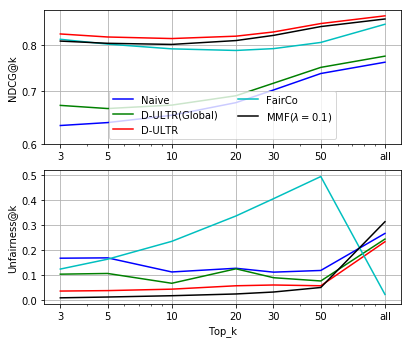

In [388]:
top_k_list=[1,3,5,10,20,30,50,100]
top_k_list_in_unfairness=[0,1,2,3,4,5,6,8]
lamb=["0.05","0.1","0.15"]
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax=ax1
method=["Naive", "D-ULTR(Global)", "D-ULTR", "FairCo"]
list_iter=[0,1,2,3]
for ind,dt_i in enumerate(data[:4]):
    cur=[np.mean(dt_i["NDCG_"+str(i)])for i in top_k_list[1:]]
    
    ax.plot(top_k_list[1:],cur,label=method[ind])
    
for i in range(1,2):
    cur=[np.mean(data[i+4]["NDCG_"+str(top)])for top in top_k_list[1:]]
    ax.plot(np.array(top_k_list[1:]),cur,\
            label="MMF($\lambda="+str(lamb[i])+"$)")
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Accumulative_NDCG@5", fontsize=15)
# plt.grid()
# plt.xscale("log")
# plt.grid()
# ax.set_xlabel("Top_k", fontsize=10)
ax.legend(ncol=2,loc=8)
ax.set_ylabel("NDCG@k", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(top_k_list[1:])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([0.6,0.7,0.8])
x_ticks_labels=["3","5","10","20","30","50","all"]
ax.set_xticklabels(x_ticks_labels, fontsize=10)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.7,0.5))
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/comparison_cumulative_ndcg.pdf", bbox_inches="tight", dpi = 200)
##Unfairness @5
ax=ax2
# ax=axx[1]
# fig, ax = plt.subplots()
method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo"]
for ind,i in enumerate(method):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[ind][top_k_list_in_unfairness[1:]],1),label=method[ind])
# ax.plot(np.array(top_k_list),top_method[:,-1],label=method[-1])

for i in range(1,2):
    ax.plot(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][top_k_list_in_unfairness[1:]],1),label="MMF($\lambda="+str(lamb[i])+"$)")
ax.set_xlabel("Top_k", fontsize=10)
ax.set_ylabel("Unfairness@k", fontsize=10)
ax.set_xscale("log")
# plt.yscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_yticks([0.0,1.0,2.0,3.0])
ax.set_xticks(top_k_list[1:])
# ax.set_ylim(0,0.05)
x_ticks_labels=["3","5","10","20","30","50","all"]
ax.set_xticklabels(x_ticks_labels, fontsize=10)
ax.grid()
# ax.legend(ncol=2,bbox_to_anchor=(0.4,0.4))
plt.savefig("plots/Asaved/batch_run/figure/paper_5.4/comparison_ndcg_unfairness_top_k.pdf", bbox_inches="tight", dpi = 600)

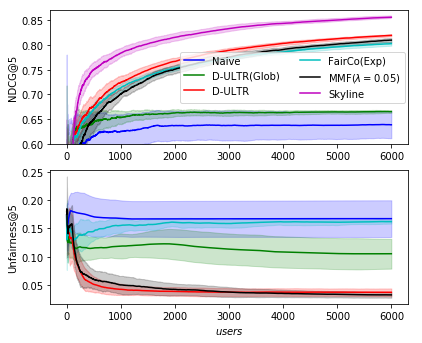

In [245]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None,ax=ax1)

for i in range(0,1):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax1)
nd=data_skyline[0]
nd=np.cumsum(nd["NDCG_5"],1)/(np.arange(1,nd["NDCG_5"].shape[-1]+1)[np.newaxis,:])
shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="Skyline",color=None,ax=ax1)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
ax1.legend(ncol=2,bbox_to_anchor=(0.35,0.27))
# ax1.set_xlabel("$users$", fontsize=15)
ax1.set_ylabel("NDCG@5", fontsize=10)
ax1.set_ylim(0.6,0.87)
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
# plt.show()
# plt.close("all")

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo(Exp)"]
labels=method
for i, nd in enumerate(data_unfairness_table_all[:4]):
#     plot_ndcg(np.mean(nd[0], axis=0), label=labels[i], plot=False, window_size=100, std=nd[0])
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),label=labels[i],color=None,ax=ax2)
for i in range(0,1):
    nd=data_unfairness_table_all[i+4]
    shaded_std(step=np.arange(nd[2].shape[-1]), mean=np.mean(nd[2], axis=0),std=np.std(nd[2], axis=0),\
               label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax2)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
ax2.set_xlabel("$users$", fontsize=10)
ax2.set_ylabel("Unfairness@5", fontsize=10)
# ax2.set_ylim(0.1,2.6)
# plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.savefig("plots/Asaved/batch_run/figure/paper_5.4/convergence_at_5.pdf", bbox_inches="tight", dpi=600)

plt.show()
#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
plt.close("all")

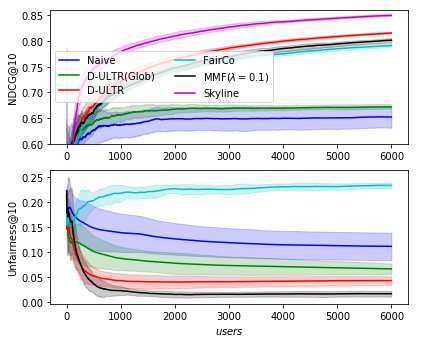

In [389]:
fig = plt.figure(figsize=[6.4,5.4])
ax_whole = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax_whole.spines['top'].set_color('none')
ax_whole.spines['bottom'].set_color('none')
ax_whole.spines['left'].set_color('none')
ax_whole.spines['right'].set_color('none')
ax_whole.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo"]
labels=method
for i, nd in enumerate(data[:4]):
    nd=np.cumsum(nd["NDCG_10"],1)/(np.arange(1,nd["NDCG_10"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(nd["NDCG_5"], axis=0), label=labels[i], plot=False, window_size=100, std=nd["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label=labels[i],color=None,ax=ax1)

for i in range(1,2):
    nd=data[i+4]
    nd=np.cumsum(nd["NDCG_10"],1)/(np.arange(1,nd["NDCG_10"].shape[-1]+1)[np.newaxis,:])
#     plot_ndcg(np.mean(data[i+4]["NDCG_5"], axis=0), label="Fair_MMR($\lambda="+str(lamb[i])+"$)", plot=False, window_size=100, std=data[i+4]["NDCG_5"])
    shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax1)
nd=data_skyline[0]
nd=np.cumsum(nd["NDCG_10"],1)/(np.arange(1,nd["NDCG_10"].shape[-1]+1)[np.newaxis,:])
shaded_std(step=np.arange(nd.shape[-1]), mean=np.mean(nd, axis=0),std=np.std(nd, axis=0),label="Skyline",color=None,ax=ax1)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# ax1.legend(ncol=2,bbox_to_anchor=(0.6,0.6))
ax1.legend(ncol=2,loc=6)
# ax1.set_xlabel("$users$", fontsize=15)
ax1.set_ylabel("NDCG@10", fontsize=10)
ax1.set_ylim(0.6,0.86)
# plt.savefig("plots/Asaved/batch_run_dataset1_greedy/figure/NDCG_5_steps.pdf", bbox_inches="tight", dpi=800)
# plt.show()
# plt.close("all")

method=["Naive", "D-ULTR(Glob)", "D-ULTR", "FairCo"]
labels=method
for i, nd in enumerate(data_unfairness_table_all[:4]):
#     plot_ndcg(np.mean(nd[0], axis=0), label=labels[i], plot=False, window_size=100, std=nd[0])
    shaded_std(step=np.arange(nd[3].shape[-1]), mean=np.mean(nd[3], axis=0),std=np.std(nd[3], axis=0),label=labels[i],color=None,ax=ax2)
for i in range(1,2):
    nd=data_unfairness_table_all[i+4]
    shaded_std(step=np.arange(nd[3].shape[-1]), mean=np.mean(nd[3], axis=0),std=np.std(nd[3], axis=0),\
               label="MMF($\lambda="+str(lamb[i])+"$)",color=None,ax=ax2)

#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
ax2.set_xlabel("$users$", fontsize=10)
ax2.set_ylabel("Unfairness@10", fontsize=10)
# ax2.set_ylim(0.1,2.6)
# plt.savefig(PLOT_PREFIX + "NDCG.pdf", bbox_inches="tight", dpi=800)
plt.savefig("plots/Asaved/batch_run/figure/paper_5.4/convergence_at_10.pdf", bbox_inches="tight", dpi=600)

plt.show()
#     plot_ndcg(np.array(top_k_list[1:]),np.mean(data_unfairness_table[i+4][1:],1),label="Fair_MMR($\lambda="+str(lamb[i])+"$)")
# plt.legend()
plt.close("all")

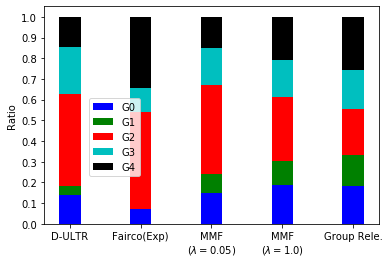

In [283]:
num_g=[]
for j in range(len(data[1]["G"])):
    num_g.append([])
    num_g_cur=num_g[-1]
    for i in data[1]["G"][j]:
#         print(len(i))
        num_g_cur.append(len(i))
num_g=np.array(num_g)
relevance=data[0]["true_rel"][0,0,:]/num_g[0]
relevance=relevance/np.sum(relevance)
ind_ratio_plot=[2,3,4,5]
ratio_list=[]
for ind in ind_ratio_plot:
    ratio=data[ind]["rank_group_split"][0][:,0]/np.sum(data[2]["rank_group_split"][0][:,0])
    ratio_list.append(ratio)
ratio_list.append(relevance)
ratio_list=np.array(ratio_list)
ratio_list=ratio_list.T
ind = np.arange(ratio_list.shape[1])
width = 0.3
p=[]
p.append( plt.bar(ind, ratio_list[0], width))
for i in range(1,ratio_list.shape[0]):
    p.append(plt.bar(ind, ratio_list[i], width,bottom=np.cumsum(ratio_list,0)[i-1]))

plt.ylabel('Ratio', fontsize=10)
# plt.title('Scores by group and gender')
plt.xticks(ind, ('D-ULTR', 'Fairco(Exp)', 'MMF\n($\lambda=0.05$)', 'MMF\n($\lambda=1.0$)', 'Group Rele.'),fontsize=10)
plt.yticks(np.arange(0, 11)/10)
plt.legend((p), ('G'+str(i) for i in range(5)),bbox_to_anchor=(0.3,0.6))

plt.savefig("plots/Asaved/batch_run_dataset2_greedy/figure/ratio.pdf", bbox_inches="tight", dpi = 600)
plt.show()